In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 

from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot

In [2]:
cell_types = ['hDL-1', 'hDL-2', 'hDL-3', 'hL2/3', 'hL4', 'hL5-1', 'hL5-2', 'hL5-3',
       'hL5-4', 'hL6-1', 'hL6-2', 'hL6-3', 'hNdnf', 'hNos', 'hPv-1',
       'hPv-2', 'hSst-1', 'hSst-2', 'hSst-3', 'hVip-1', 'hVip-2', 'unlabeled']

cell_classes = ['exci', 'exci', 'exci', 'exci', 'exci', 'exci', 'exci', 'exci',
       'exci', 'exci', 'exci', 'exci', 'inhi', 'inhi', 'inhi',
       'inhi', 'inhi', 'inhi', 'inhi', 'inhi', 'inhi', 'glia']

df_cell_class = pd.DataFrame()
df_cell_class['cell_type'] = cell_types
df_cell_class['cell_class'] = cell_classes
df_cell_class = df_cell_class.set_index('cell_type')
df_cell_class

cell_class
cell_type           
hDL-1           exci
hDL-2           exci
hDL-3           exci
hL2/3           exci
hL4             exci
hL5-1           exci
hL5-2           exci
hL5-3           exci
hL5-4           exci
hL6-1           exci
hL6-2           exci
hL6-3           exci
hNdnf           inhi
hNos            inhi
hPv-1           inhi
hPv-2           inhi
hSst-1          inhi
hSst-2          inhi
hSst-3          inhi
hVip-1          inhi
hVip-2          inhi
unlabeled       glia

In [3]:
mc_c_file = './data/gene_level/genebody_mCG_human_combined_summary.tsv'
df = pd.read_table(mc_c_file, index_col='id')
print(df.shape)

(57240, 12870)


In [4]:
meta_file = './data/metadata/metadata_human_combined_updated.tsv' 
cluster_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain.tsv'
tsne_file = './data/tsne/tsne_perp30_binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
gene_id_name_file = './data/references/gene_id_to_names.tsv'
annotation_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain_annotation.tsv'

df_meta = pd.read_table(meta_file, index_col='Sample')
df_cluster = pd.read_table(cluster_file, index_col='sample')
df_tsne = pd.read_table(tsne_file, index_col='sample')
df_gene = pd.read_table(gene_id_name_file, index_col='geneID')
df_annot = pd.read_table(annotation_file, index_col='cluster_ID').fillna('unlabeled')

df_cluster = pd.merge(df_cluster, df_annot, left_on='cluster_ID', right_index=True)
df_cluster = pd.merge(df_cluster, df_cell_class, left_on='cluster_annotation', right_index=True)

print(df_meta.shape)
print(df_tsne.shape)
print(df_cluster.shape)
print(df_gene.shape)

df_info = pd.merge(df_meta, df_cluster, left_index=True, right_index=True)
df_info = pd.merge(df_info, df_tsne, left_index=True, right_index=True)
print(df_info.shape)

(6435, 16)
(6435, 2)
(6435, 3)
(57820, 5)
(6435, 21)


In [5]:
df_mc = df.filter(regex='_mc')
df_c = df.filter(regex='_c')

df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns]
df_c.columns = [col[:-len('_c')] for col in df_c.columns]

print(df_mc.shape)
print(df_c.shape)


# cells = df_info[df_info.cluster_ID=='cluster_52'].index.values
# cells_1 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_v1')].index.values
# cells_2 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_EA')].index.values
# cells_3 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_EB')].index.values
# print(cells.shape)
# print(cells_1.shape)
# print(cells_2.shape)
# print(cells_3.shape)

(57240, 6435)
(57240, 6435)


In [6]:
# filter out genes with low coverage
# doing imputation
# get gene*cell matrix

# cutoff = 100
# cov = (df_c >= cutoff)*1
# gene_cov = cov.apply(np.all, axis=1)
# df_mccf = df_mcc.loc[gene_cov, :]
# print(df_mccf.shape)
# sns.heatmap(cov)
# plt.show()# low coverage


# remove low coverage gene

base_call_cutoff = 10 
sufficient_coverage_fraction = 0.95 
condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 


print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
print(df_mcc.shape)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'


Matrix size before pruning... (57240, 12870)
Matrix size after pruning... (9387, 12870)
(9387, 6435)
Imputing data...


# End of preprocessing

2784
2347
1304


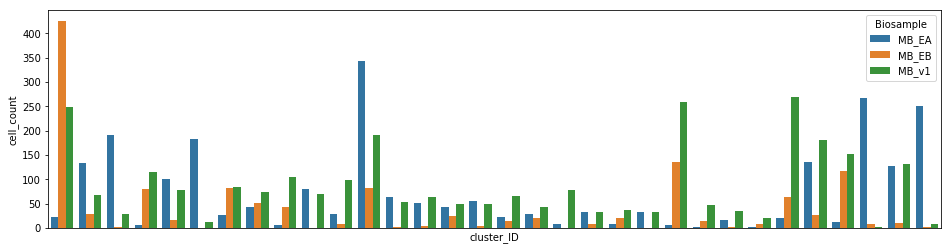

In [12]:
"""
For every cluster, plot biosample related quantities
"""
cell_count1 = df_info[df_info.Biosample=='MB_v1'].shape[0]
cell_count2 = df_info[df_info.Biosample=='MB_EA'].shape[0]
cell_count3 = df_info[df_info.Biosample=='MB_EB'].shape[0]
print(cell_count1)
print(cell_count2)
print(cell_count3)

df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts)
ax.set_xticks([])
plt.show()

In [17]:
df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster

print(df_counts_new.shape)
df_counts_new.head()

(92, 7)


cluster_ID Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0   cluster_1     MB_EA          23          2347    0.009800         698   
1   cluster_1     MB_EB         426          1304    0.326687         698   
2   cluster_1     MB_v1         249          2784    0.089440         698   
3  cluster_10     MB_EA         134          2347    0.057094         230   
4  cluster_10     MB_EB          28          1304    0.021472         230   

   cell_ratio_cluster  
0            0.000014  
1            0.000468  
2            0.000128  
3            0.000248  
4            0.000093

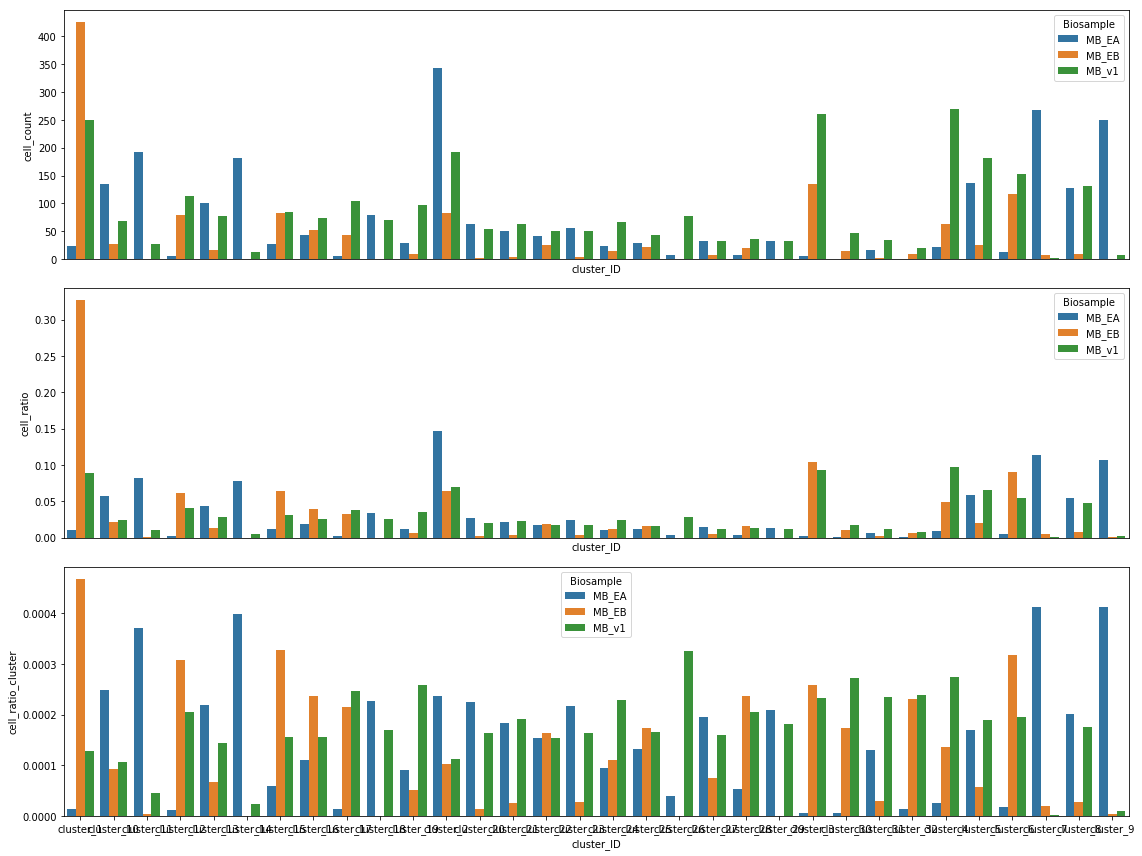

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
fig.tight_layout()
plt.show()

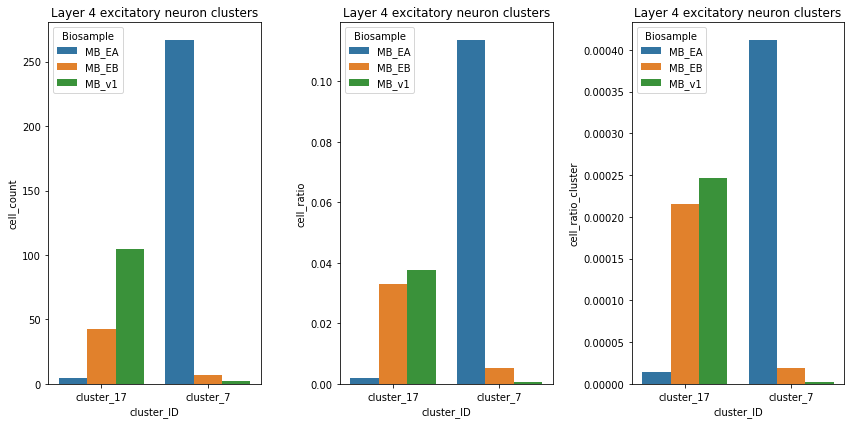

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID.isin(['cluster_7', 'cluster_17'])], ax=ax)
# ax.set_xticks([])
ax.set_title('Layer 4 excitatory neuron clusters')
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID.isin(['cluster_7', 'cluster_17'])], ax=ax)
# ax.set_xticks([])
ax.set_title('Layer 4 excitatory neuron clusters')
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID.isin(['cluster_7', 'cluster_17'])], ax=ax)
ax.set_title('Layer 4 excitatory neuron clusters')
fig.tight_layout()
plt.show()

In [33]:
df_counts_2 = df_info.groupby(['cluster_annotation', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_2 = df_counts_2.reset_index(level=['cluster_annotation', 'Biosample'])
df_counts_2.columns = ['cluster_annotation', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_2 = pd.merge(df_counts_2, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_2['cell_ratio'] = df_counts_new_2.cell_count/df_counts_new_2.tc_biosample

df_cluster_counts = df_info.groupby('cluster_annotation').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_2 = pd.merge(df_counts_new_2, df_cluster_counts, left_on='cluster_annotation', right_index=True)
df_counts_new_2['cell_ratio_cluster'] = df_counts_new_2.cell_ratio/df_counts_new_2.tc_cluster

df_counts_new_2.head()

array(['hDL-1', 'hDL-2', 'hL2/3', 'hL4', 'hL5-1', 'hL5-2', 'hL5-3',
       'hL5-4', 'hL6-1', 'hL6-2', 'hL6-3', 'hNdnf', 'hNos', 'hPv-1',
       'hPv-2', 'hSst-2', 'hSst-3', 'hVip-1', 'hVip-2'], dtype=object)

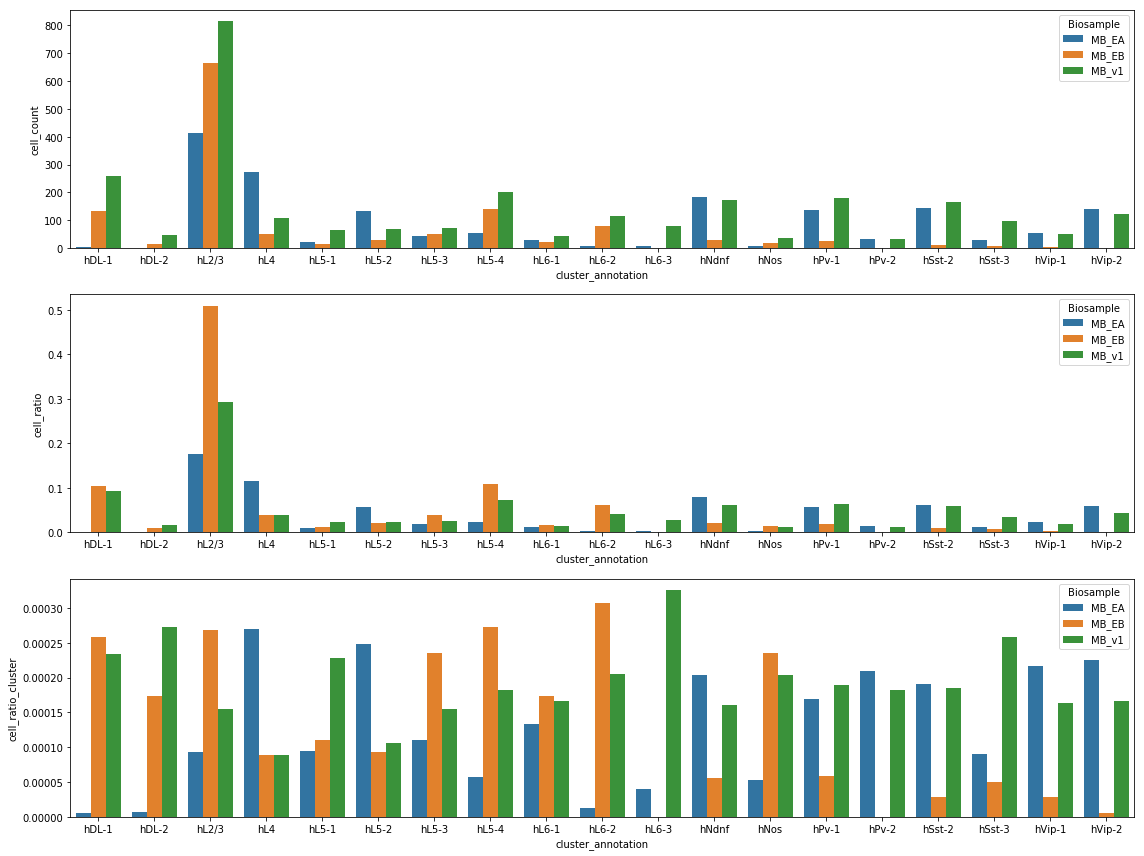

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_annotation", y="cell_count", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_annotation", y="cell_ratio", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_annotation", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_2, ax=ax)
fig.tight_layout()
plt.show()

In [61]:
df_counts_3 = df_info.groupby(['cell_class', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_3 = df_counts_3.reset_index(level=['cell_class', 'Biosample'])
df_counts_3.columns = ['cell_class', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_3 = pd.merge(df_counts_3, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_3['cell_ratio'] = df_counts_new_3.cell_count/df_counts_new_3.tc_biosample

df_cluster_counts = df_info.groupby('cell_class').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_3 = pd.merge(df_counts_new_3, df_cluster_counts, left_on='cell_class', right_index=True)
df_counts_new_3['cell_ratio_cluster'] = df_counts_new_3.cell_ratio/df_counts_new_3.tc_cluster

df_counts_new_3

cell_class Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0       exci     MB_EA         991          2347    0.422241        4066   
1       exci     MB_EB        1201          1304    0.921012        4066   
2       exci     MB_v1        1874          2784    0.673132        4066   
3       glia     MB_EA         624          2347    0.265871         674   
4       glia     MB_EB           2          1304    0.001534         674   
5       glia     MB_v1          48          2784    0.017241         674   
6       inhi     MB_EA         732          2347    0.311888        1695   
7       inhi     MB_EB         101          1304    0.077454        1695   
8       inhi     MB_v1         862          2784    0.309626        1695   

   cell_ratio_cluster  
0            0.000104  
1            0.000227  
2            0.000166  
3            0.000394  
4            0.000002  
5            0.000026  
6            0.000184  
7            0.000046  
8            0.000183

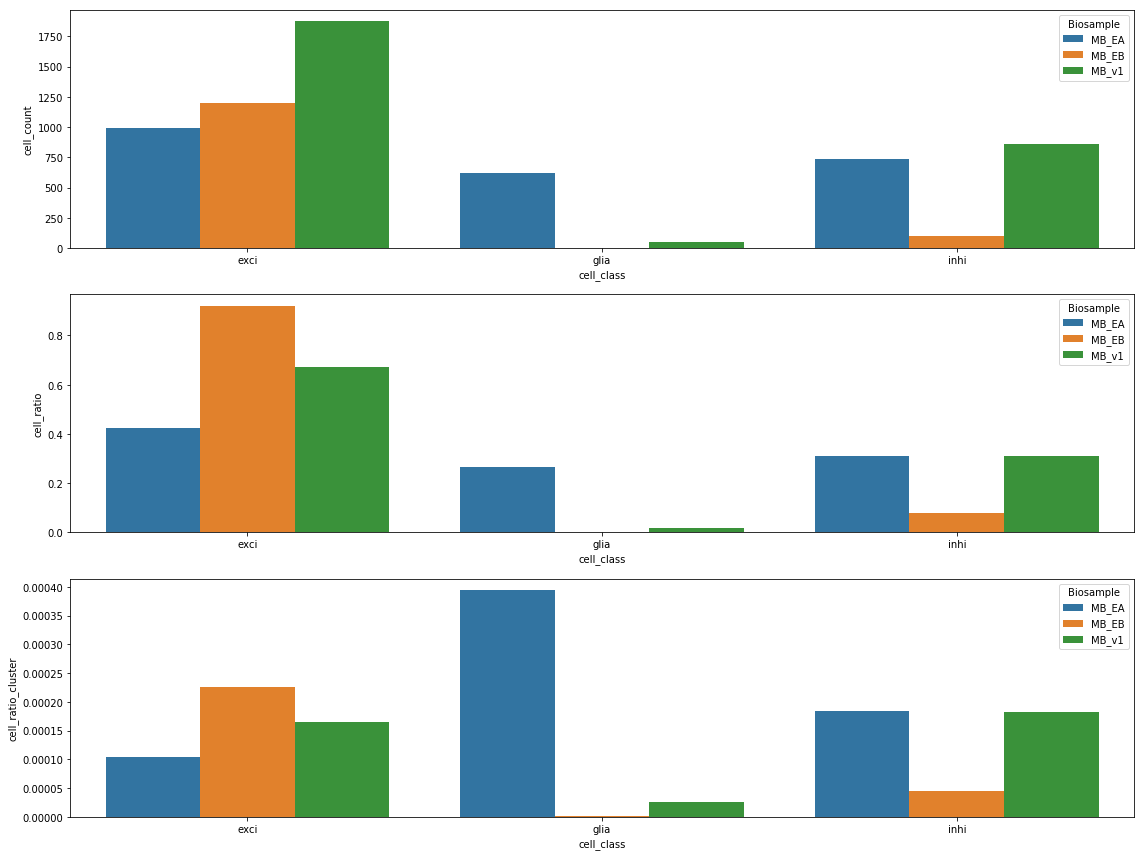

In [62]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cell_class", y="cell_count", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cell_class", y="cell_ratio", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cell_class", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_3, ax=ax)
fig.tight_layout()
plt.show()

# Analysis of variances

In [7]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

# ANOVAs for each gene and each cluster

In [8]:
# ANOVAs for each gene

# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    SSt = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

In [9]:
# F-stat, p-values

I = 3
df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
df_p = pd.DataFrame()
for col in df_F.columns:
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

hDL-1     hDL-2         hL2/3       hL4     hL5-1  \
id                                                                         
ENSG00000000460.12  0.978612  0.940911  7.717143e-01  0.034866  0.635046   
ENSG00000001084.6   0.545630  0.458486  1.497765e-02  0.944397  0.833626   
ENSG00000001460.13  0.197968  0.521822  3.729959e-01  0.494679  0.692868   
ENSG00000001461.12  0.051285  0.353428  7.660581e-06  0.192663  0.021092   
ENSG00000001617.7   0.520951  0.576465  4.400796e-08  0.704981  0.956216   

                       hL5-2     hL5-3     hL5-4     hL6-1     hL6-2  \
id                                                                     
ENSG00000000460.12  0.264965  0.188734  0.100207  0.704138  0.851776   
ENSG00000001084.6   0.054854  0.370239  0.470373  0.847785  0.706018   
ENSG00000001460.13  0.673279  0.219723  0.307129  0.079517  0.353972   
ENSG00000001461.12  0.967475  0.687125  0.686438  0.757281  0.375242   
ENSG00000001617.7   0.486974  0.294014  0.015859  0.427079  0.007475   

                       hL6-3     hNdnf      hNos     hPv-1     hPv-2  \
id                                                                     
ENSG00000000460.12  0.605051  0.120637  0.232743  0.345709  0.561594   
ENSG00000001084.6   0.235847  0.294570  0.414228  0.195958  0.464366   
ENSG00000001460.13  0.675337  0.002016  0.436019  0.512942  0.599379   
ENSG00000001461.12  0.610091  0.792852  0.168508  0.012982  0.914680   
ENSG00000001617.7   0.788861  0.997384  0.104176  0.538124  0.332278   

                      hSst-2    hSst-3    hVip-1    hVip-2  unlabeled  
id                                                                     
ENSG00000000460.12  0.099775  0.994070  0.716927  0.570546   0.756507  
ENSG00000001084.6   0.911899  0.021615  0.118001  0.286838   0.322944  
ENSG00000001460.13  0.889427  0.995026  0.830096  0.677979   0.956808  
ENSG00000001461.12  0.160154  0.135339  0.338478  0.076166   0.089137  
ENSG00000001617.7   0.055879  0.576787  0.498387  0.889467   0.088018

In [10]:
df_sst.head()

hDL-1     hDL-2      hL2/3        hL4     hL5-1  \
id                                                                        
ENSG00000000460.12   2.488290  0.198811  11.734326   2.060771  0.621236   
ENSG00000001084.6   11.109537  1.636976  51.251474  10.758516  3.211076   
ENSG00000001460.13   8.681543  1.022565  39.072146   7.738007  1.970562   
ENSG00000001461.12   4.346835  0.483010  21.544732   3.965535  1.082693   
ENSG00000001617.7   14.982190  2.415946  64.680433  12.612076  3.393967   

                       hL5-2     hL5-3      hL5-4     hL6-1     hL6-2  \
id                                                                      
ENSG00000000460.12  1.225438  1.147562   3.039193  0.551342  1.145794   
ENSG00000001084.6   6.663803  5.754955  12.355794  3.038293  5.827400   
ENSG00000001460.13  4.147282  4.237358   9.088099  2.216806  4.867194   
ENSG00000001461.12  1.881721  2.738857   5.813631  1.039410  2.612816   
ENSG00000001617.7   7.584871  6.527494  12.374311  2.743253  7.024436   

                       hL6-3      hNdnf      hNos      hPv-1     hPv-2  \
id                                                                       
ENSG00000000460.12  0.841209   2.103838  0.345790   1.888882  0.254358   
ENSG00000001084.6   2.933663   9.512573  1.598268   9.360854  1.708462   
ENSG00000001460.13  1.325553   6.347865  1.038120   6.514495  0.814742   
ENSG00000001461.12  1.120765   5.440352  0.901846   2.891864  0.544544   
ENSG00000001617.7   2.994716  12.748045  1.790485  13.048392  1.880286   

                       hSst-2    hSst-3    hVip-1    hVip-2  unlabeled  
id                                                                      
ENSG00000000460.12   1.527591  0.727360  0.608035  1.040178   3.826793  
ENSG00000001084.6    8.473253  3.721490  2.607367  6.738758  16.683537  
ENSG00000001460.13   5.732665  2.963752  1.607706  4.426758  13.619139  
ENSG00000001461.12   4.637879  1.773634  1.081286  2.556533   9.034964  
ENSG00000001617.7   13.552401  4.939794  2.761878  9.252986  21.242370

In [11]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
I = 3
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

## Plots of ANOVA

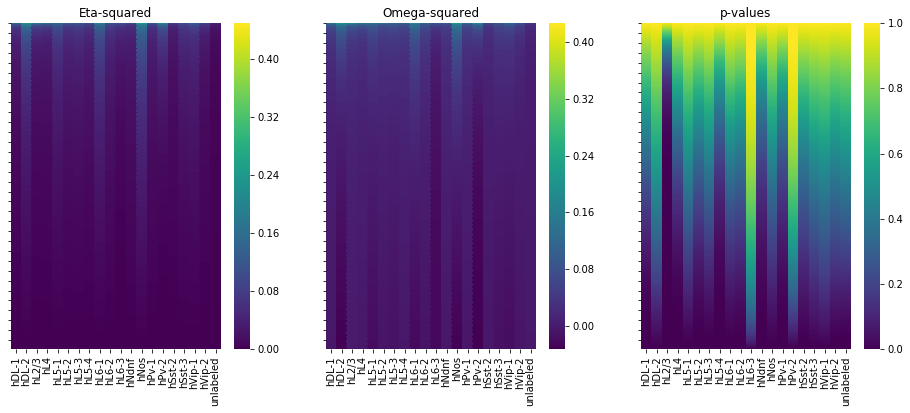

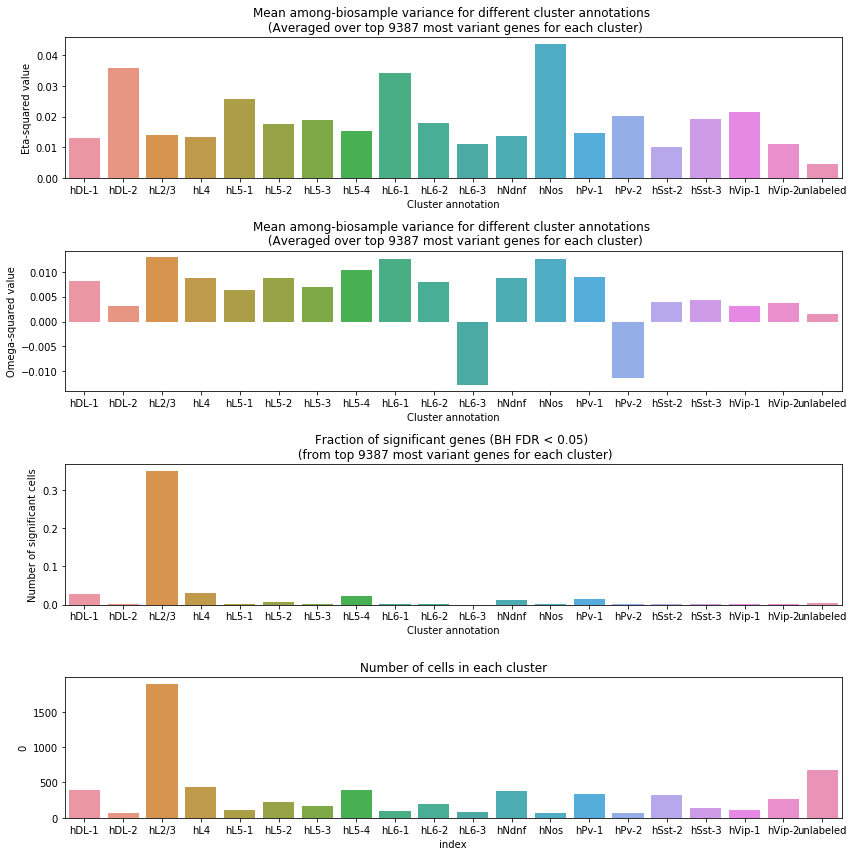

In [12]:
# eta-squared, omega-squared, and p-values 

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()



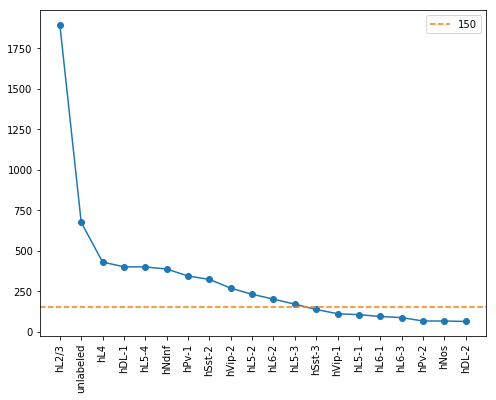

hDL-1         400
hL2/3        1894
hL4           429
hL5-2         230
hL5-3         169
hL5-4         399
hL6-2         200
hNdnf         386
hPv-1         343
hSst-2        322
hVip-2        268
unlabeled     674
dtype: int64

In [13]:
# number of cells in each cluster

sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x='index', y=0, data=sr_n.sort_values(ascending=False).to_frame().reset_index(), ax=ax)
# ax.set_title('Number of cells in each cluster')

ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=150, ls='dashed', color='C1', label='150')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 150)].index)]
sr_n_tr

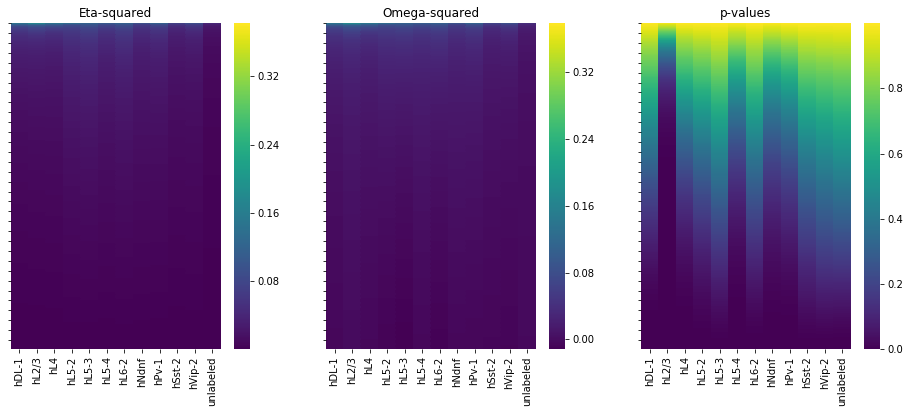

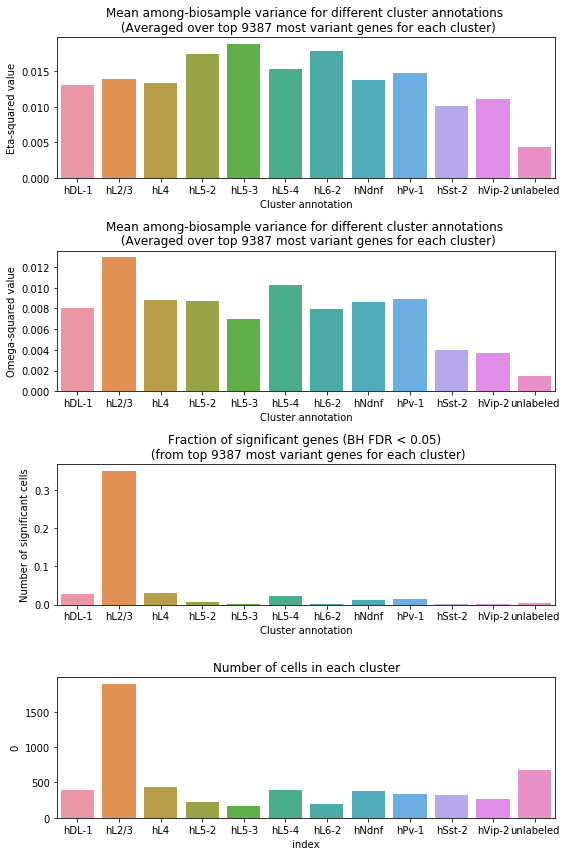

In [16]:
# rerun with truncated set of celltypes

# eta-squared, omega-squared, and p-values 

cell_types_tr = sr_n_tr.index.values  

df_res1 = df_eta[cell_types_tr]
df_res2 = df_ome[cell_types_tr]
df_res3 = df_p[cell_types_tr]
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_res3.columns:
    rejs, *dis = multipletests(df_res3[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(8, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n_tr.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()


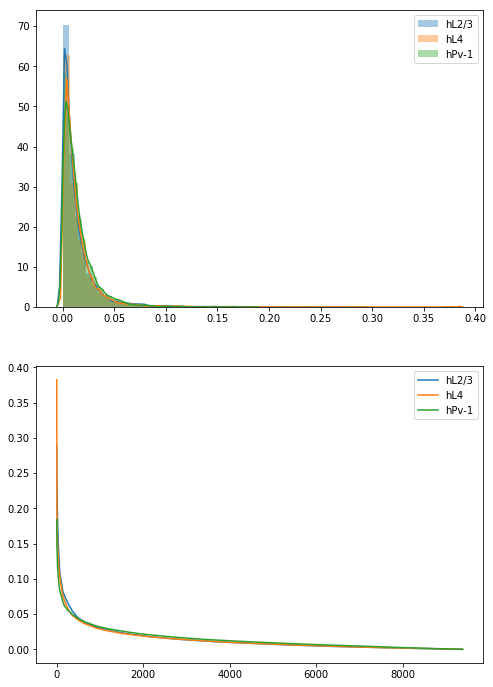

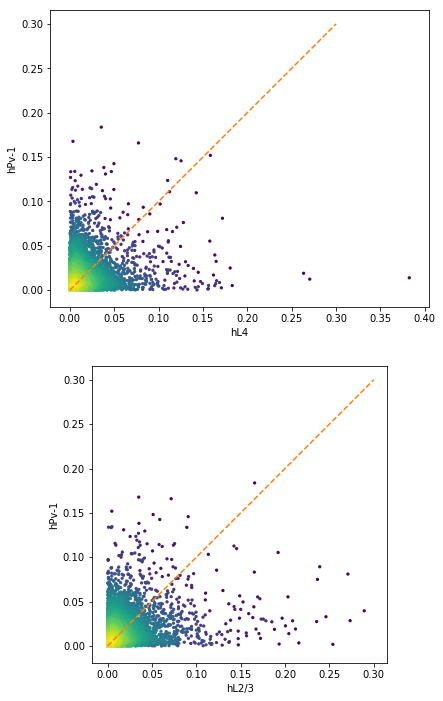

In [17]:
# eta-squared 
df_res = df_eta 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
sns.distplot(df_res['hL2/3'].values, ax=ax, label='hL2/3')
sns.distplot(df_res['hL4'].values, ax=ax, label='hL4')
# sns.distplot(df_res['hL5-2'].values, ax=ax, label='hL5-2')
sns.distplot(df_res['hPv-1'].values, ax=ax, label='hPv-1')
# sns.distplot(df_res['hNdnf'].values, ax=ax, label='hNdnf')
ax.legend()

ax = axs[1]
ax.plot(df_res_ordered['hL2/3'].values, label='hL2/3')
ax.plot(df_res_ordered['hL4'].values, label='hL4')
# ax.plot(df_res_ordered['hL5-2'].values, label='hL5-2')
ax.plot(df_res_ordered['hPv-1'].values, label='hPv-1')
# ax.plot(df_res_ordered['hNdnf'].values, label='hNdnf')
# ax.set_yscale('log')
ax.legend()
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
xy = np.vstack([df_res['hL4'].values, df_res['hPv-1'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['hL4'].values, df_res['hPv-1'].values, c=np.log10(z), s=5)
ax.set_xlabel('hL4')
ax.set_ylabel('hPv-1')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')

ax = axs[1]
xy = np.vstack([df_res['hL2/3'].values, df_res['hPv-1'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['hL2/3'].values, df_res['hPv-1'].values, c=np.log10(z), s=5)
ax.set_xlabel('hL2/3')
ax.set_ylabel('hPv-1')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')
plt.show()



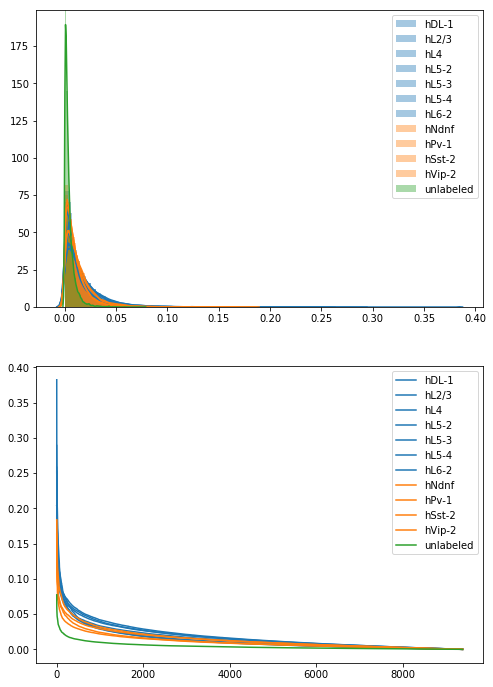

In [57]:
# eta-squared

# df_cell_class.loc[cell_types_tr].groupby('cell_class')


df_res = df_eta[cell_types_tr] 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C2')
ax.legend()

ax = axs[1]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        ax.plot(df_res_ordered[col].values, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        ax.plot(df_res_ordered[col].values, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        ax.plot(df_res_ordered[col].values, label=col, color='C2')
ax.legend()
plt.show()



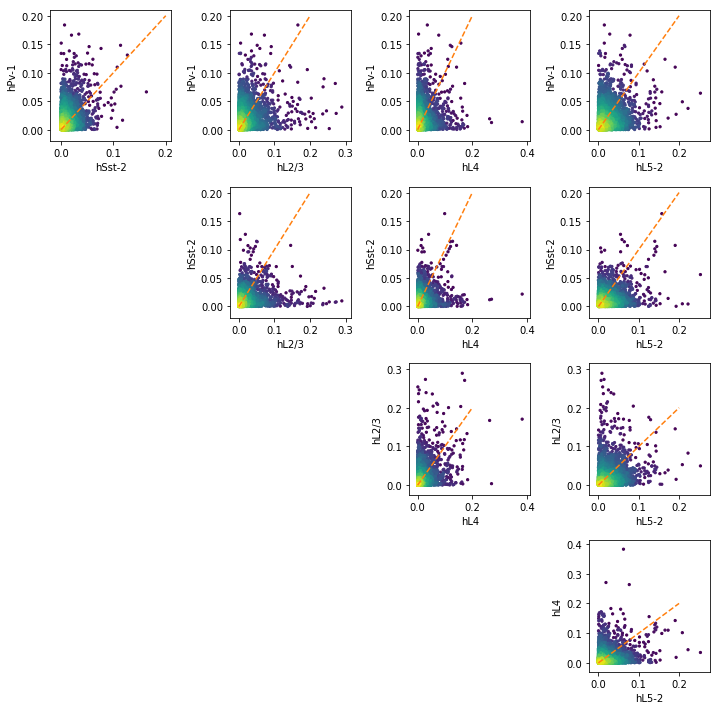

In [20]:
# hPv-1, hSst-2, hL2/3, hL4, hL5-2

cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)

fig, axs = plt.subplots(n, n, figsize=(12, 12))
for i, j in zip(*np.tril_indices_from(axs, k=0)):
    axs[i, j].set_visible(False)
for i, j in zip(*np.triu_indices_from(axs, k=1)):
    ax = axs[i, j]
    cti = cell_types_tr2[j]
    ctj = cell_types_tr2[i]
    xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
    z = gaussian_kde(xy)(xy)
    ax.scatter(df_res[cti].values, df_res[ctj].values, c=np.log10(z), s=5)
    ax.set_xlabel(cti)
    ax.set_ylabel(ctj)
    line_x = np.arange(0, 0.3, 0.1)
    line_y = np.arange(0, 0.3, 0.1)
    ax.plot(line_x, line_y, '--', color='C1')
    ax.set_aspect('auto')
    
fig.tight_layout()
plt.show()



# Look at one cell type (hL4)

In [29]:
# repeat with different n 

# take top n genes for hL4

# classifier LDA   

# evaluate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype):
    cells = df_info[df_info.cluster_annotation==celltype].index.values
    cells_v1 = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_v1')].index.values
    cells_EA = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EA')].index.values
    cells_EB = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EB')].index.values
#     print(np.asarray([cells_v1.shape[0], cells_EA.shape[0], cells_EB.shape[0]])/cells.shape[0])

    # generate data
    cells = df_info[df_info['cluster_annotation']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells+'_mcc'].T 
    X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
    X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    return df_xy0, df_xy1
    

In [30]:

def LDA_xvalid(df_xy, n_splits=5):
    """
    X = regex="^ENSG"
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
    n_tops = np.arange(1, 100, 2)
    # n_tops = np.arange(1, 100, 5)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^ENSG')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^ENSG')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            lda = LDA().fit(X_train, y_train)
            y_pred = lda.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


/cndd/fangming/venvs/venv_dobro_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_dobro_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


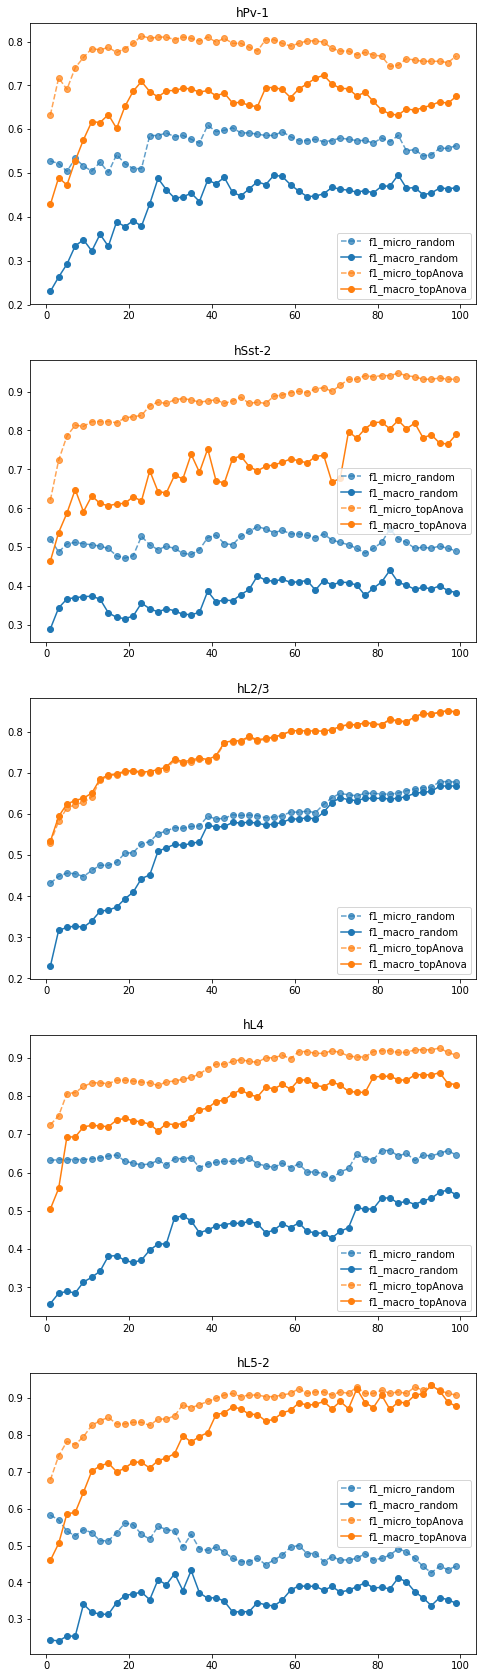

In [31]:
cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)
n_tops = np.arange(1, 100, 2)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0)
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1)

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [32]:
# What are the top 30 genes?
n_top = 30
sr_top_genes = df_gene.loc[df_p['hL4'].sort_values().index.values[:n_top], 'geneName']
sr_top_genes.to_frame()


geneName
geneID                            
ENSG00000048740.13           CELF2
ENSG00000081248.6          CACNA1S
ENSG00000273079.1           GRIN2B
ENSG00000205464.7         ATP6AP1L
ENSG00000214216.6             IQCJ
ENSG00000081189.9            MEF2C
ENSG00000188580.9           NKAIN2
ENSG00000116852.10          KIF21B
ENSG00000176463.9          SLCO3A1
ENSG00000151474.15          FRMD4A
ENSG00000223727.2       AC026188.1
ENSG00000153707.11           PTPRD
ENSG00000144460.10           NYAP2
ENSG00000196628.9             TCF4
ENSG00000162105.12          SHANK2
ENSG00000185565.7            LSAMP
ENSG00000033122.14           LRRC7
ENSG00000184613.6            NELL2
ENSG00000189319.9           FAM53B
ENSG00000187122.12           SLIT1
ENSG00000053108.12           FSTL4
ENSG00000139973.11           SYT16
ENSG00000154978.8            VOPP1
ENSG00000269891.1   ARHGAP19-SLIT1
ENSG00000224905.2       AP001347.6
ENSG00000257156.1      RP11-13A1.3
ENSG00000257271.1      KIRREL3-AS1
ENSG00000149294.12           NCAM1
ENSG00000258628.1     RP11-492D6.3
ENSG00000166501.8            PRKCB

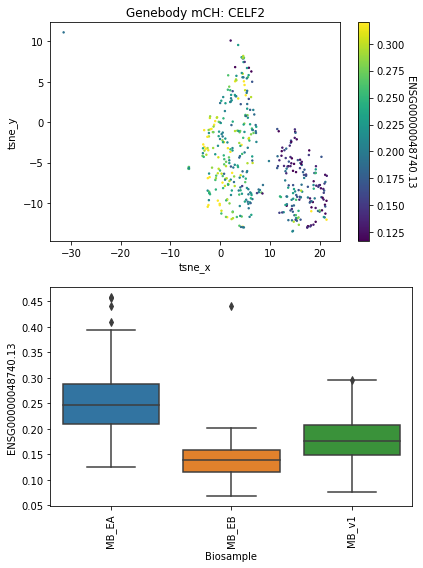

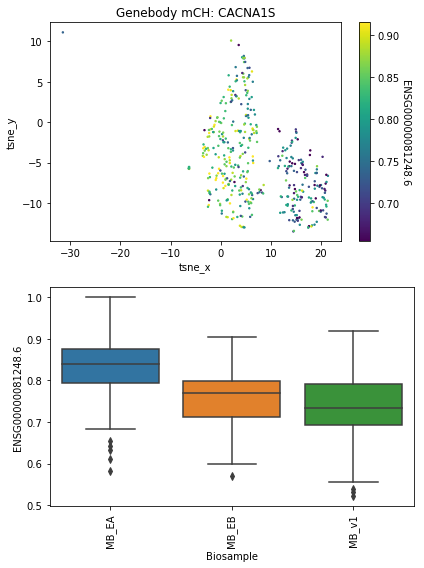

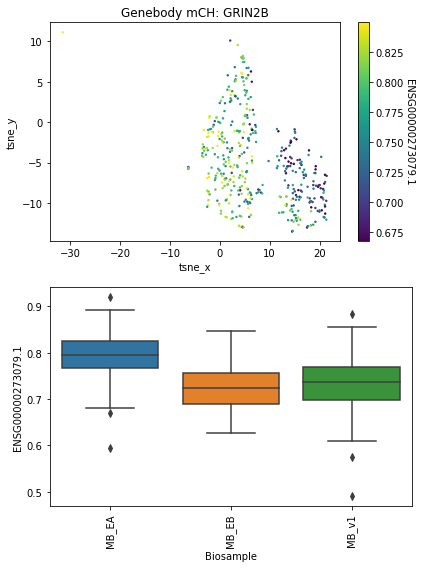

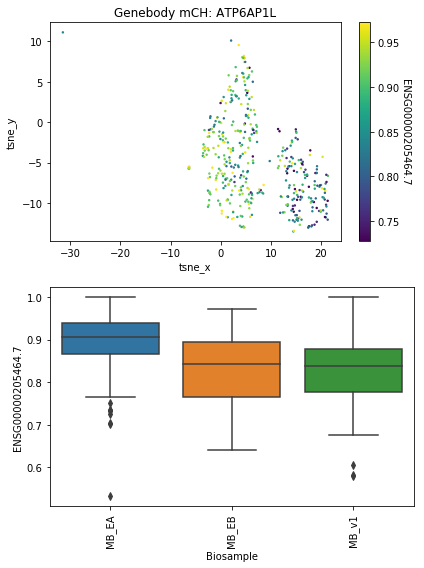

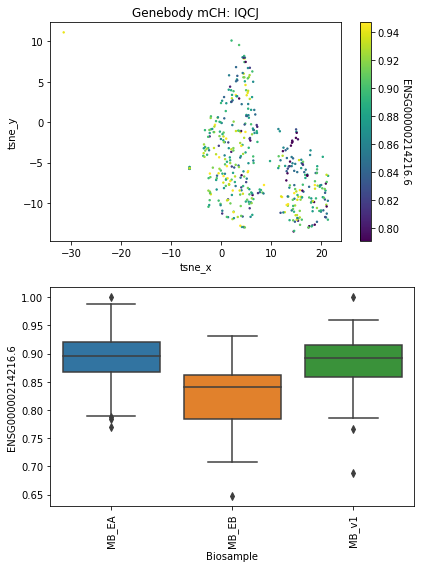

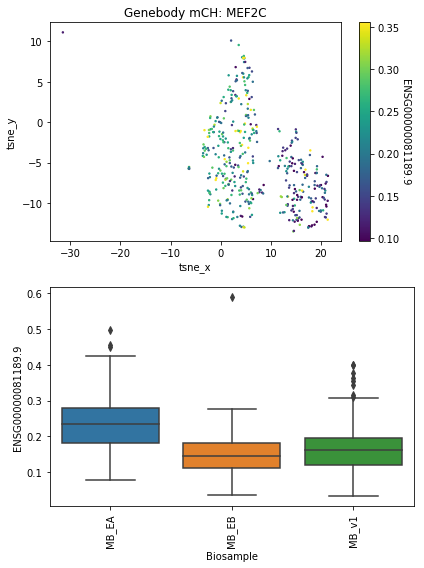

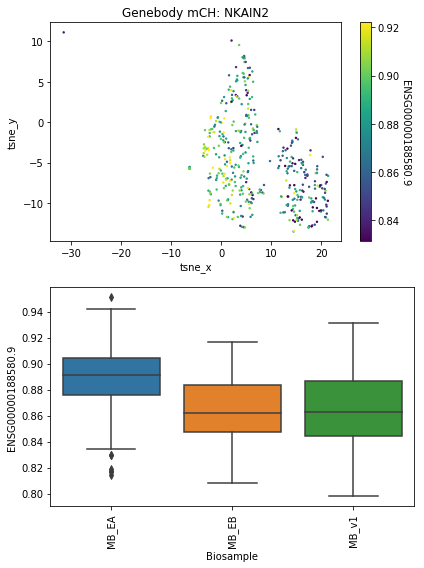

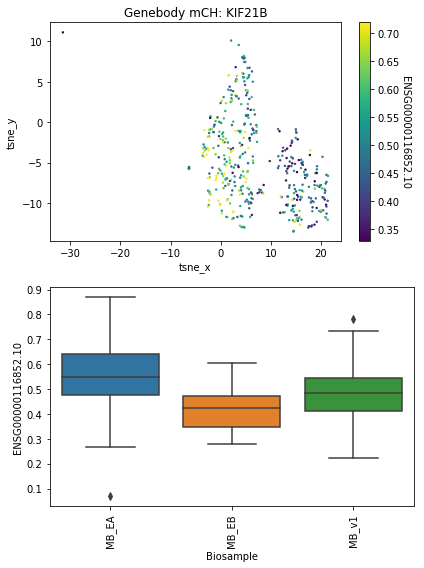

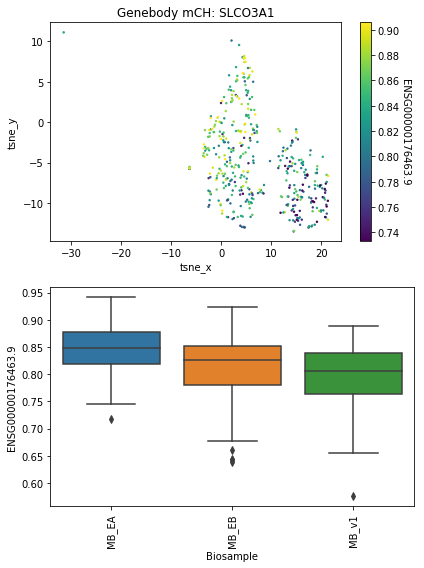

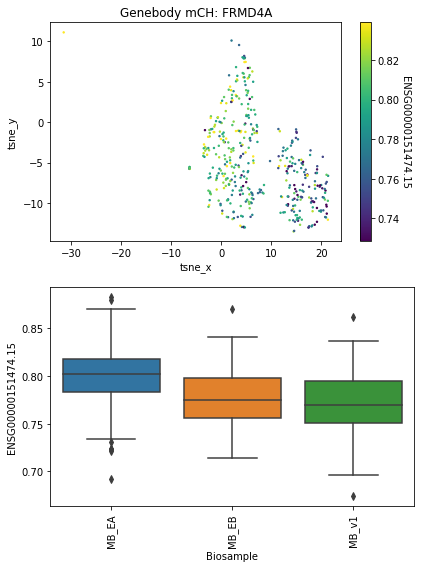

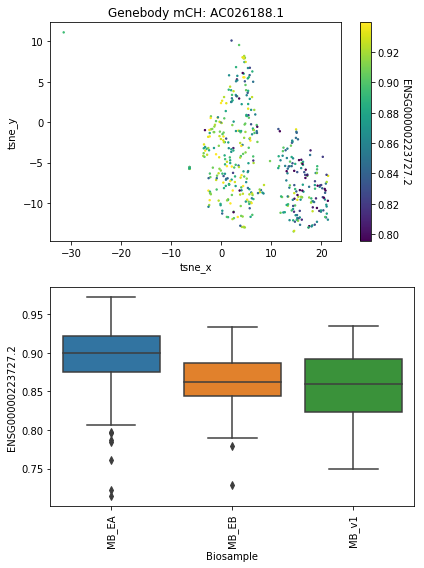

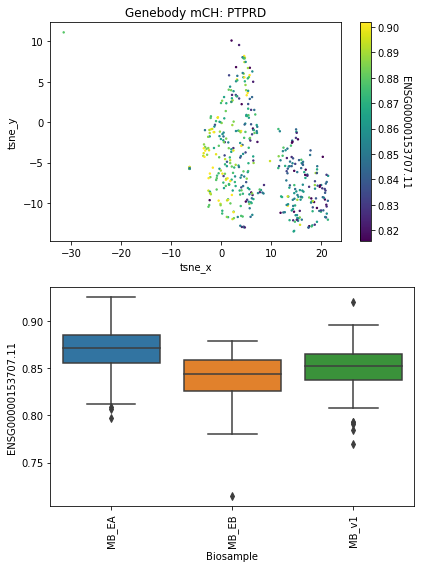

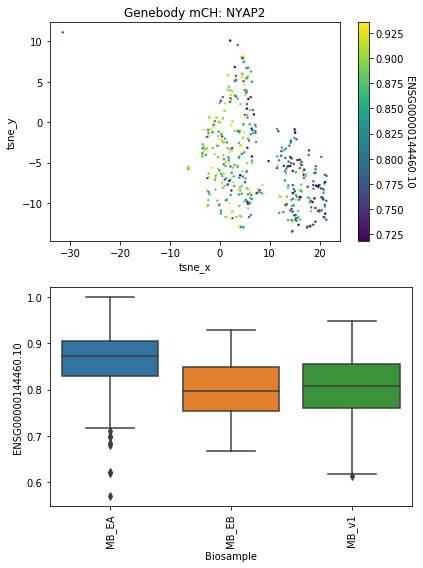

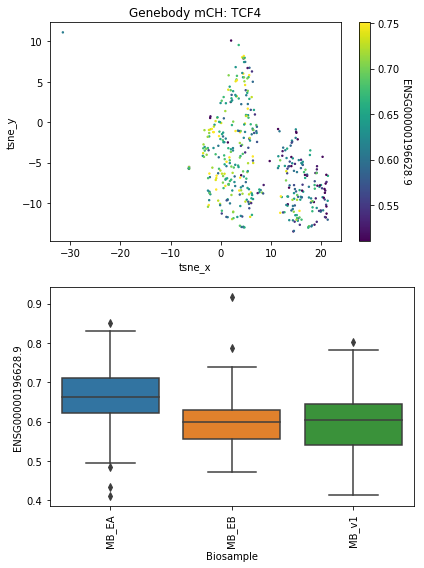

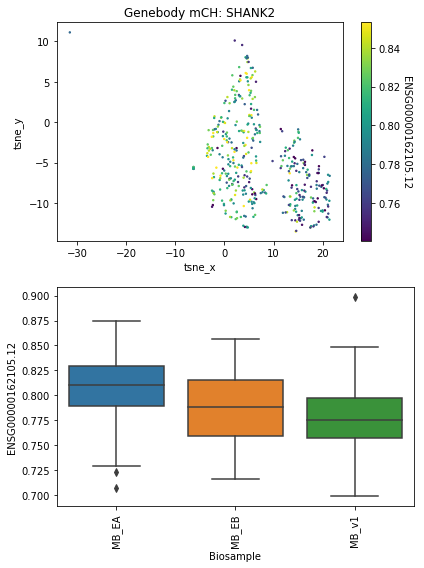

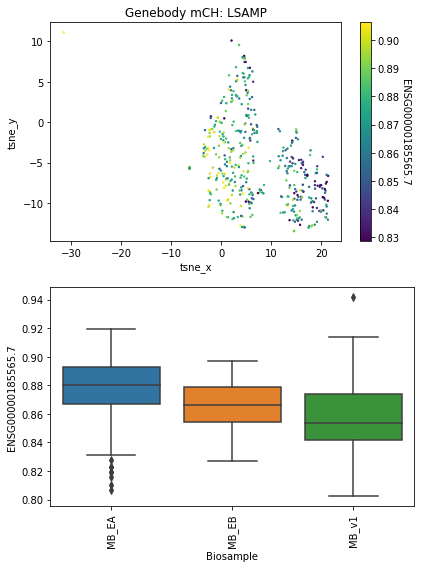

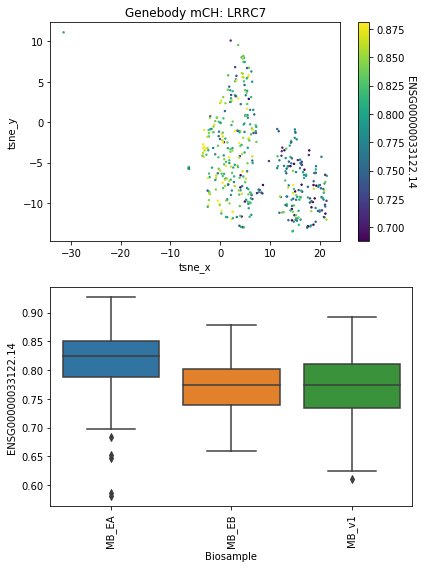

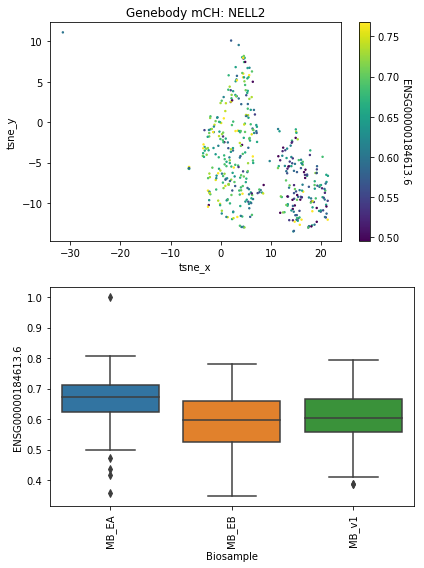

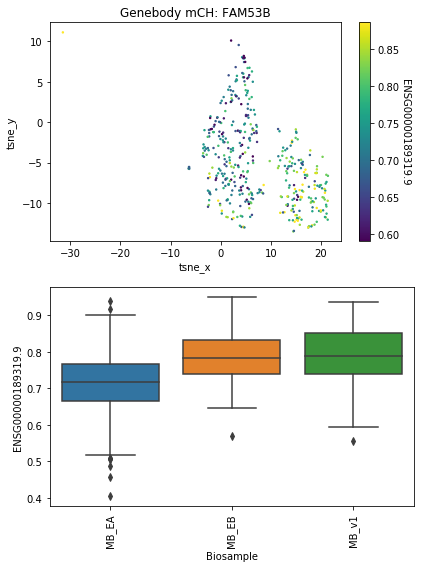

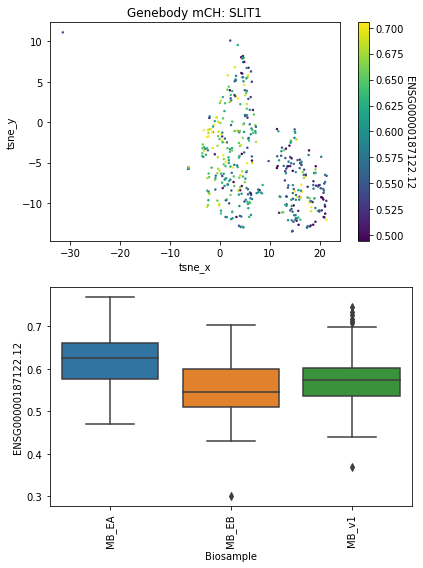

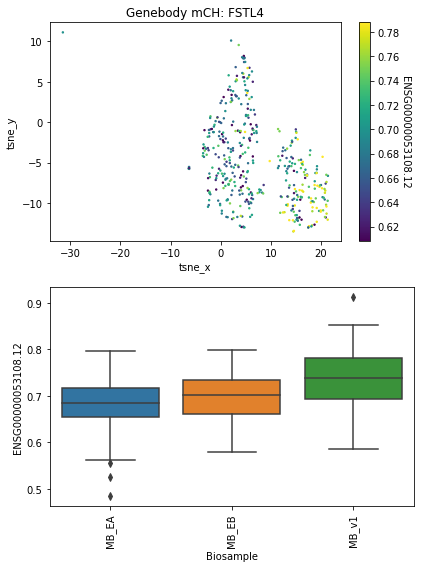

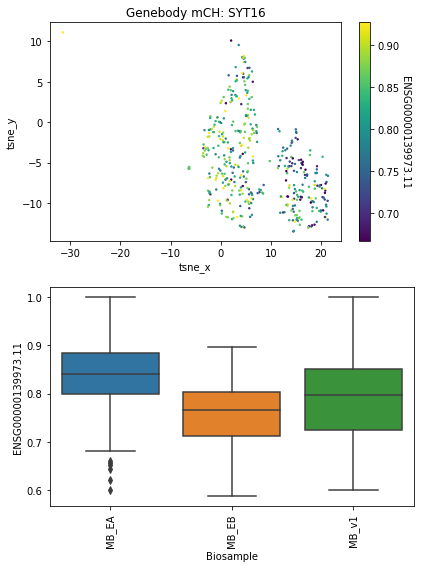

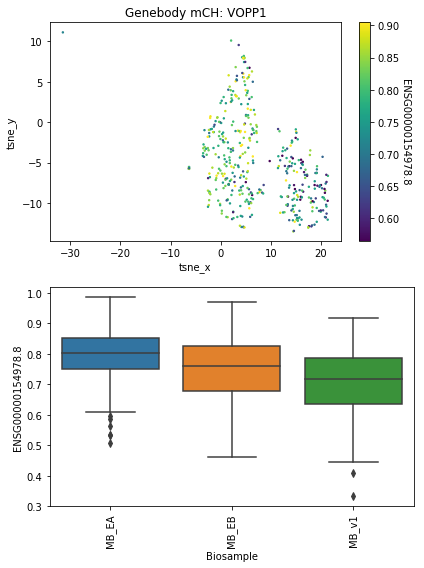

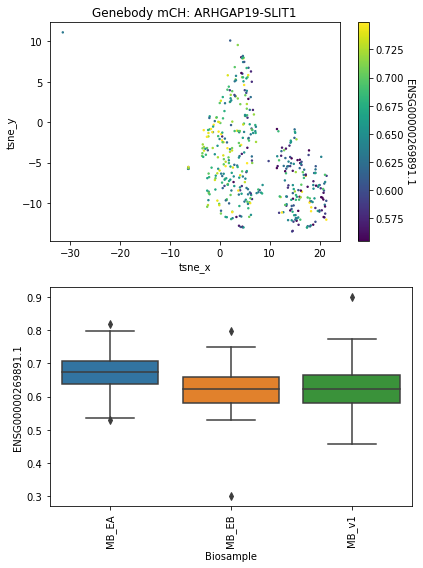

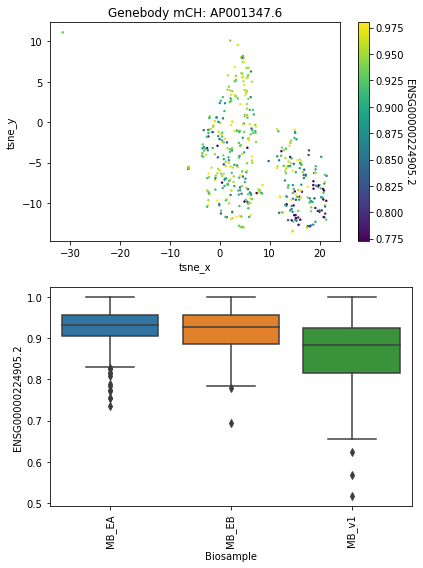

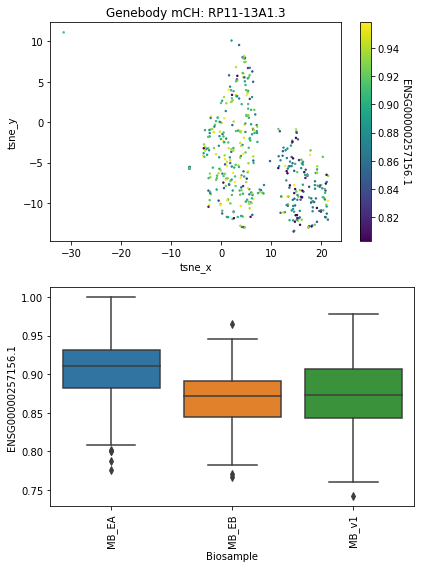

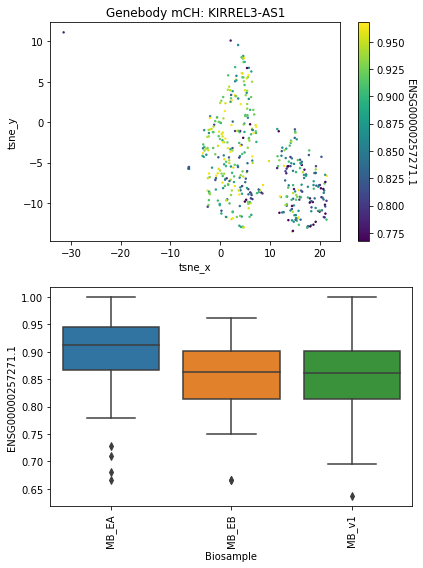

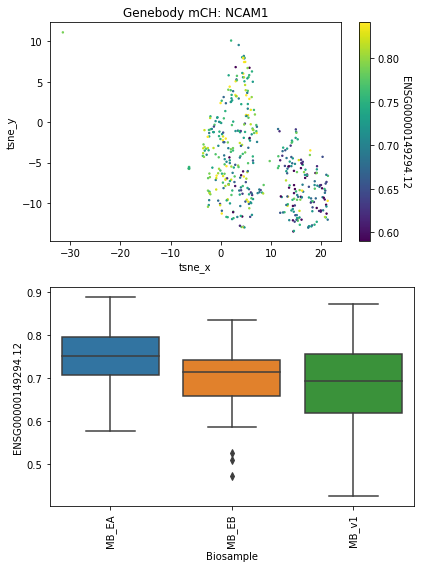

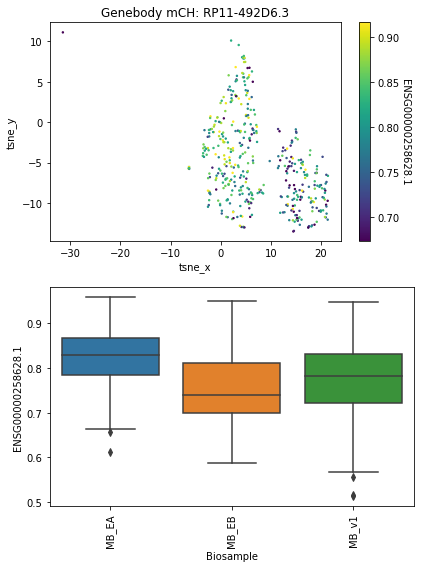

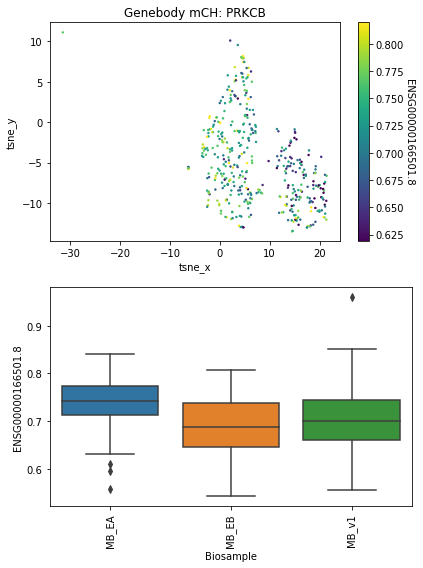

In [34]:
# Look at those genes in detail
# tsne and boxplot


df_xy0, df_xy1 = get_data('hL4')

for gene_id, gene_name in sr_top_genes.iteritems():
    df_plot = pd.merge(df_info, df_xy1[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)


# ICA marker genes (see if the lists converge)

1. run PCA, reduce dimensions of feature space (genes)

2. run ICA in PC spaces

3. identify certain interesting ICs
    - plot ICs against each other

    - plot IC on tSNE

4. Plot IC coefficients, look at top genes



In [36]:

df_xy = df_xy1
df_x = df_xy.filter(regex='^ENSG')
print(df_x.shape)
df_x.head()


(429, 9387)


ENSG00000048740.13  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed            0.202358   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed            0.219124   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed            0.218593   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed            0.252252   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed            0.263158   

                                                   ENSG00000081248.6  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.857143   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.828571   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.875000   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.897959   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.867769   

                                                   ENSG00000273079.1  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.740947   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.808511   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.760181   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.825112   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.795539   

                                                   ENSG00000205464.7  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.863636   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.791667   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           1.000000   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.850746   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.927273   

                                                   ENSG00000214216.6  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.942149   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.872340   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.914530   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.873016   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.842593   

                                                   ENSG00000081189.9  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.166667   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.282353   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.357895   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.295082   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.175439   

                                                   ENSG00000188580.9  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.870558   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.902027   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.887640   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.901235   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.888078   

                                                   ENSG00000116852.10  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed            0.666667   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed            0.448276   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed            0.505051   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed            0.617021   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed            0.720000   

                                                   ENSG00000176463.9  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.834320   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.835165   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.859316   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.855385   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.867987   

                                                   ENSG00000151474.15  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed            0.778680

In [37]:
# ICA workflow


n_comp = 10
# fit PCA
pca = PCA(n_components=n_comp).fit(df_x)
pcs = pca.transform(df_x)

df_pc_axis = pd.DataFrame(pca.components_, 
                       index=['PC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

df_pc_axis.head()


ENSG00000048740.13  ENSG00000081248.6  ENSG00000273079.1  \
PC1            0.009280           0.014149           0.007656   
PC2            0.047975           0.039818           0.035020   
PC3            0.001268          -0.015702          -0.007033   
PC4           -0.001212           0.016414          -0.007652   
PC5           -0.004730          -0.002720          -0.004747   

     ENSG00000205464.7  ENSG00000214216.6  ENSG00000081189.9  \
PC1           0.008889           0.004085           0.005883   
PC2           0.032674           0.016208           0.037377   
PC3          -0.004237           0.004724          -0.003180   
PC4           0.006959          -0.016243           0.006460   
PC5          -0.007108           0.002169          -0.011702   

     ENSG00000188580.9  ENSG00000116852.10  ENSG00000176463.9  \
PC1           0.003811            0.009808           0.008924   
PC2           0.010650            0.058772           0.021507   
PC3          -0.003606           -0.002960          -0.002505   
PC4          -0.002055           -0.006162          -0.005473   
PC5           0.001170           -0.004765          -0.000097   

     ENSG00000151474.15        ...          ENSG00000132164.5  \
PC1            0.007827        ...                   0.003018   
PC2            0.011561        ...                   0.008407   
PC3           -0.004041        ...                   0.007294   
PC4           -0.001266        ...                  -0.006181   
PC5           -0.007392        ...                  -0.010499   

     ENSG00000171055.10  ENSG00000164626.8  ENSG00000076554.11  \
PC1            0.006607           0.007465            0.003963   
PC2            0.002294          -0.003099           -0.002861   
PC3            0.003499          -0.004409            0.001664   
PC4           -0.003865           0.011916            0.004053   
PC5            0.007448           0.002883           -0.000838   

     ENSG00000064270.8  ENSG00000153207.10  ENSG00000073331.13  \
PC1           0.004108            0.007413            0.001758   
PC2          -0.003941           -0.002982            0.003802   
PC3           0.004463            0.020215           -0.002937   
PC4           0.005078            0.002849           -0.007318   
PC5          -0.006651            0.014642            0.019033   

     ENSG00000121671.7  ENSG00000137843.7  ENSG00000009694.9  
PC1           0.008677           0.010956           0.002159  
PC2           0.006320          -0.003582          -0.000122  
PC3           0.015594          -0.013532          -0.000274  
PC4          -0.004403          -0.019303          -0.002786  
PC5          -0.020102          -0.023217          -0.002634  

[5 rows x 9387 columns]

In [38]:
# visualize PCA
# np.cov(pcs.T)
# np.diag(np.cov(pcs.T).diagonal())



In [39]:
# ICA after PCA and reconstruct data
# manual whitening
C = np.sqrt(np.diag(np.cov(pcs.T).diagonal()))
pcsw = np.dot(pcs, np.linalg.inv(C))
# check if whitened
# print(np.cov(pcsw.T))

# fit ICA
ica = FastICA(whiten=False).fit(pcsw)
ics = ica.transform(pcsw)
df_ics = pd.DataFrame(ics, columns=['IC'+str(i+1) for i in range(n_comp)], index=df_x.index)

axis = np.dot(np.dot(ica.components_, C), pca.components_)
df_ic_axis = pd.DataFrame(axis, 
                       index=['IC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

(429, 31)


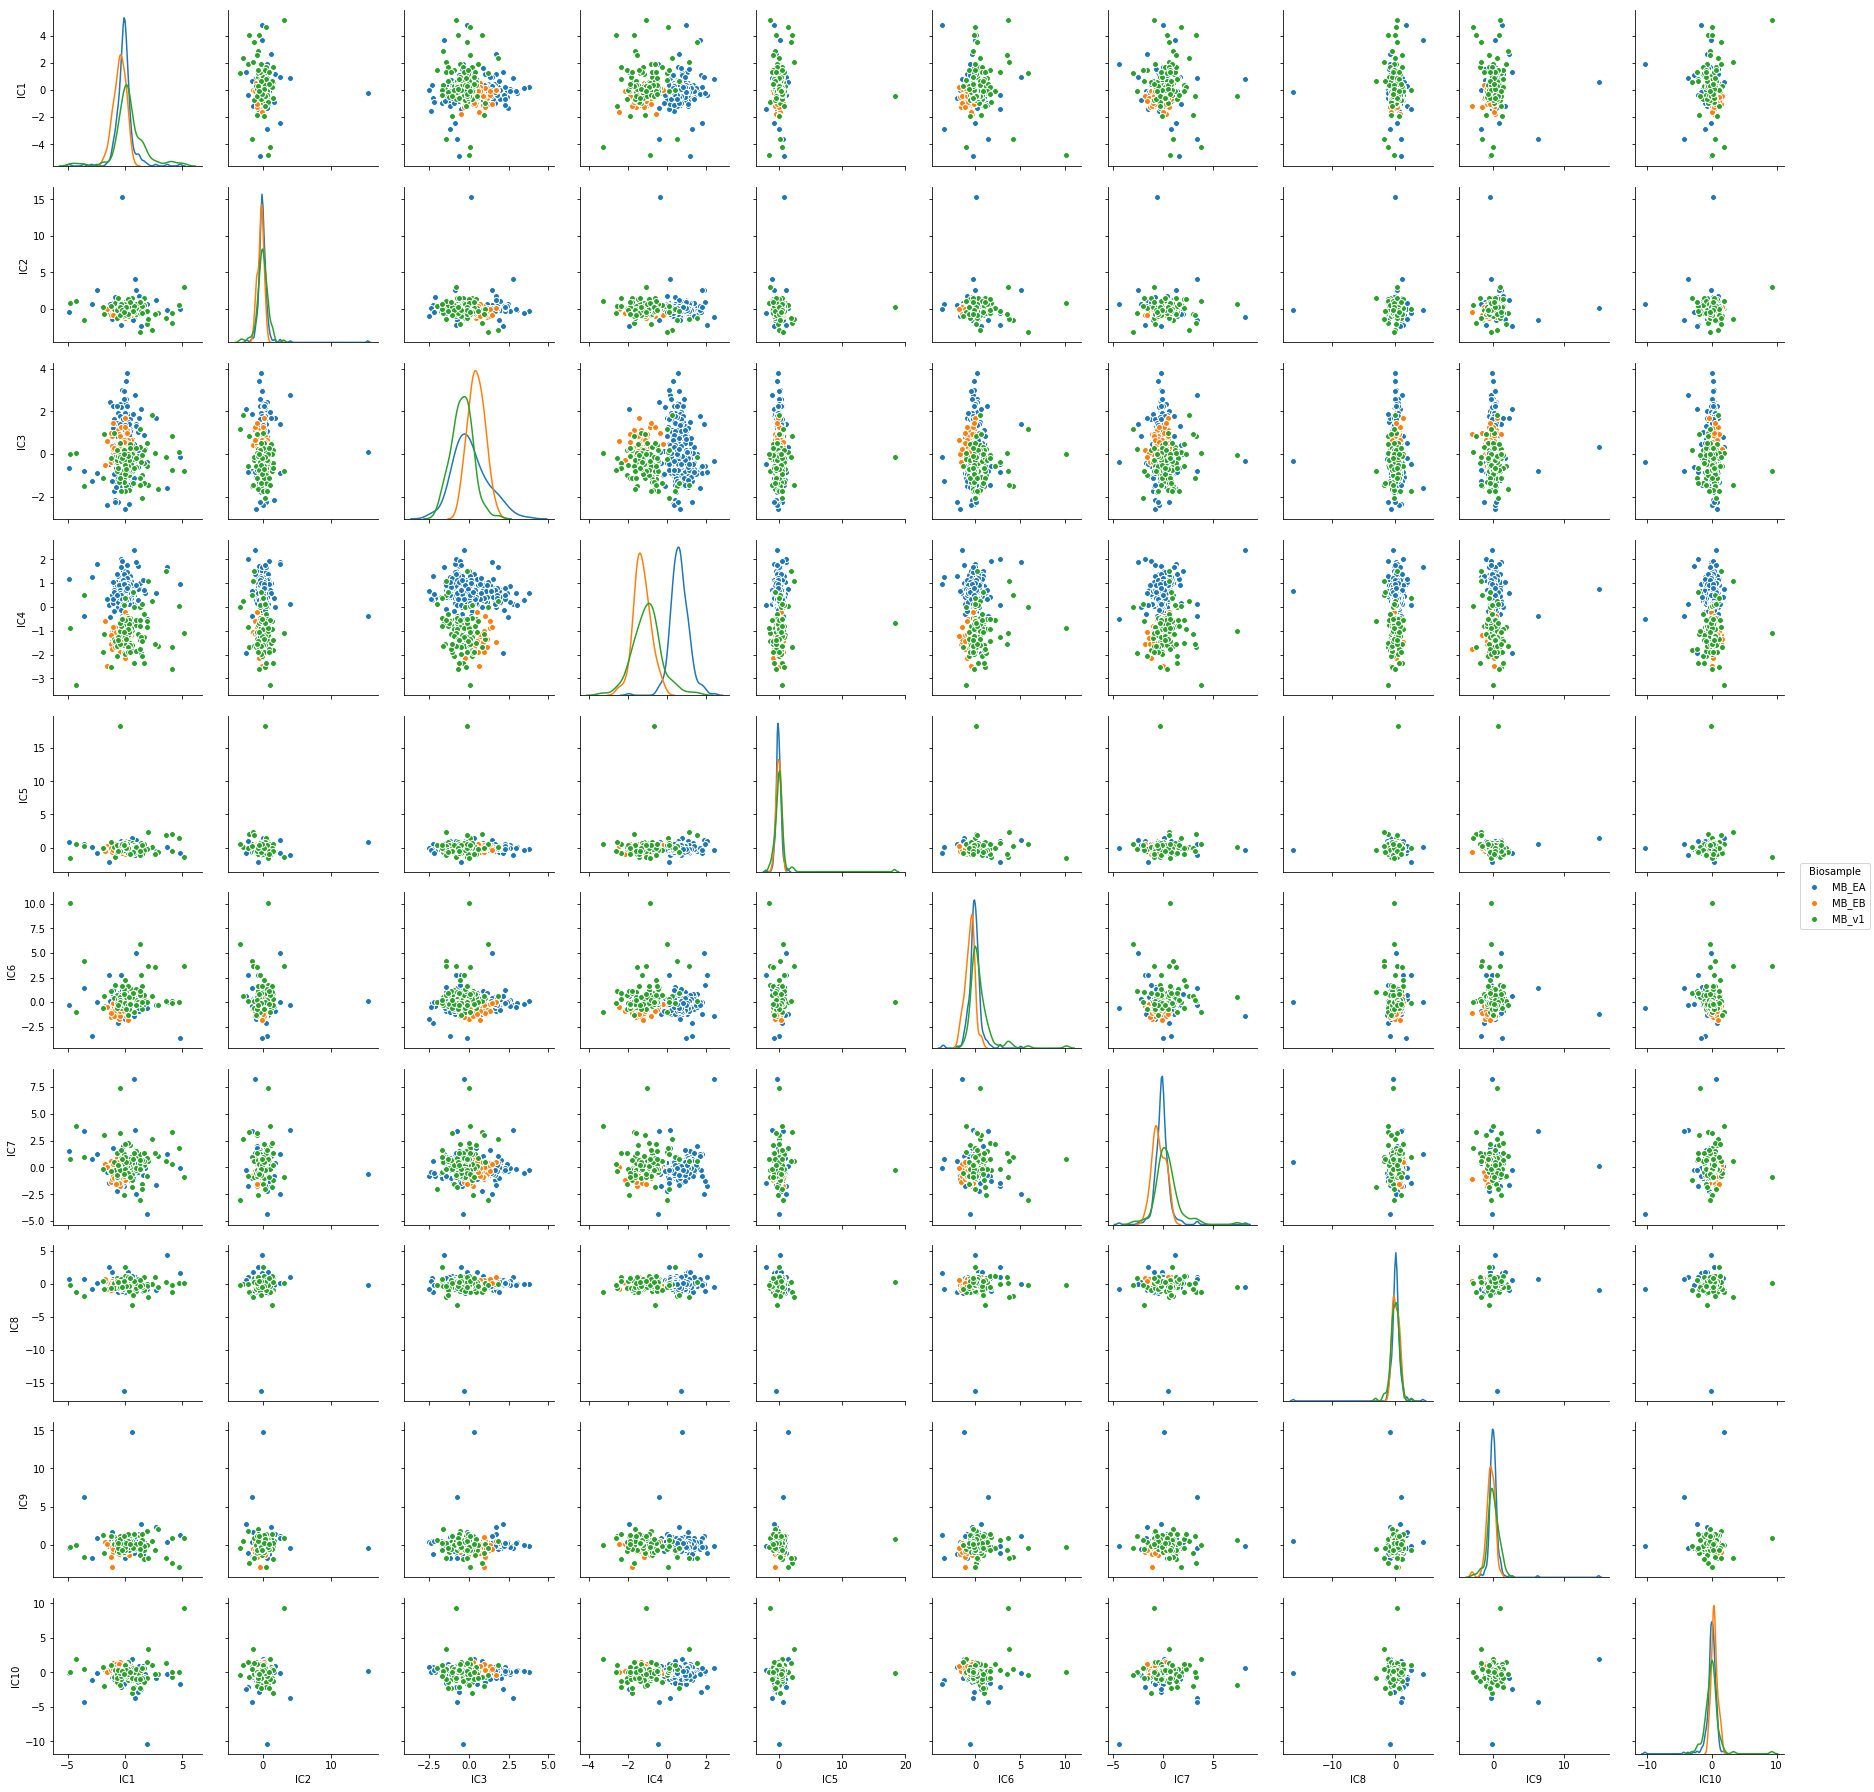

In [40]:
# plot ICs

df_plot_ics = pd.merge(df_ics, df_info, left_index=True, right_index=True)
print(df_plot_ics.shape)

g = sns.pairplot(df_plot_ics[df_ics.columns.tolist() + ['Biosample']], hue='Biosample', 
                 diag_kind='kde', markers='o', size=2.5)
# print(g.axes.shape)
# for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
#     g.axes[i, j].set_visible(False)
plt.show()

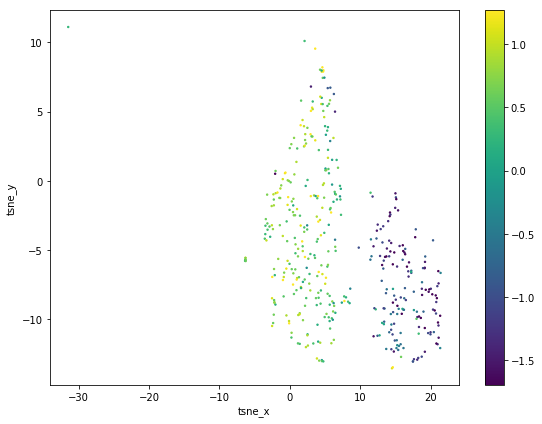

In [41]:
# plot IC tsne
plot_tsne_values(df_plot_ics, tc='IC4')

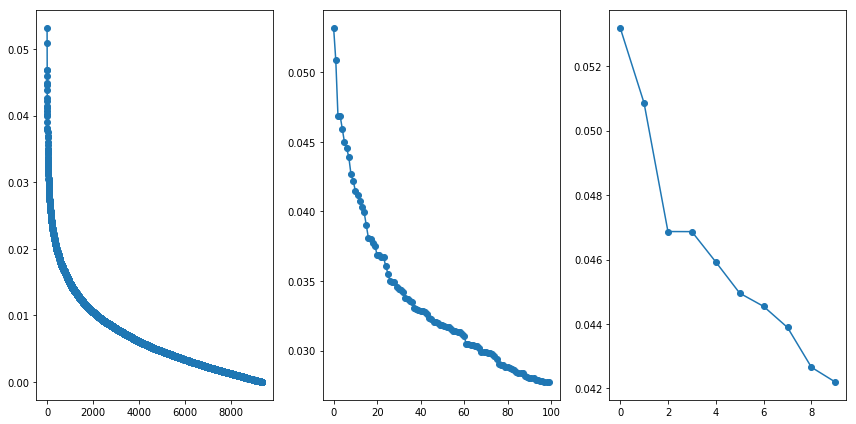

In [43]:
# 
# look at IC1 (which seperates MB_EA from other biosamples)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
icc = df_ic_axis.loc['IC4', :].apply(np.abs).sort_values(ascending=False)
ax = axs[0]
ax.plot(icc.values, 'o-')
ax = axs[1]
ax.plot(icc.values[:100], 'o-')
ax = axs[2]
ax.plot(icc.values[:10], 'o-')
fig.tight_layout()
plt.show()

In [44]:
# what are those genes
n_top = 30
sr_top_genes_2 = df_gene.loc[icc.index.values[:n_top], 'geneName']
sr_top_genes_2.to_frame()

geneName
geneID                         
ENSG00000116852.10       KIF21B
ENSG00000171631.10        P2RY6
ENSG00000213639.5        PPP1CB
ENSG00000138623.5        SEMA7A
ENSG00000122254.6        HS3ST2
ENSG00000130479.6         MAP1S
ENSG00000090376.4         IRAK3
ENSG00000132639.8        SNAP25
ENSG00000261864.1   RP11-67A1.2
ENSG00000126583.6         PRKCG
ENSG00000100364.14     KIAA0930
ENSG00000081248.6       CACNA1S
ENSG00000048740.13        CELF2
ENSG00000071127.12         WDR1
ENSG00000139722.2        VPS37B
ENSG00000010295.15        IFFO1
ENSG00000071626.12       DAZAP1
ENSG00000152484.9         USP12
ENSG00000161082.8         CELF5
ENSG00000269915.1    AP006621.9
ENSG00000140488.10        CELF6
ENSG00000163932.9         PRKCD
ENSG00000172995.12       ARPP21
ENSG00000074590.9         NUAK1
ENSG00000203685.5       C1orf95
ENSG00000205268.6         PDE7A
ENSG00000159674.7         SPON2
ENSG00000189319.9        FAM53B
ENSG00000133056.9       PIK3C2B
ENSG00000081189.9         MEF2C

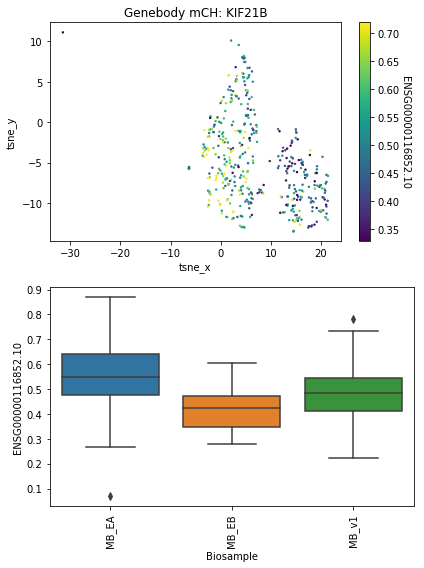

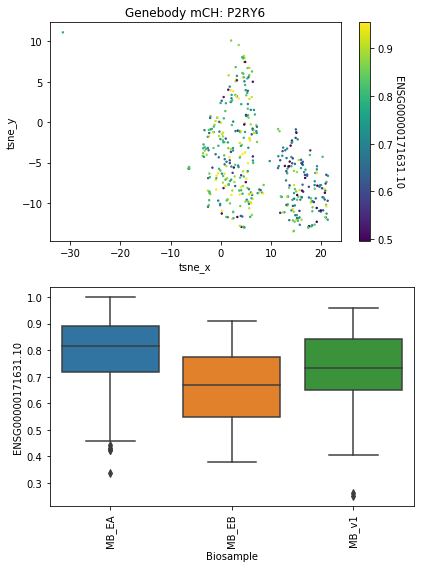

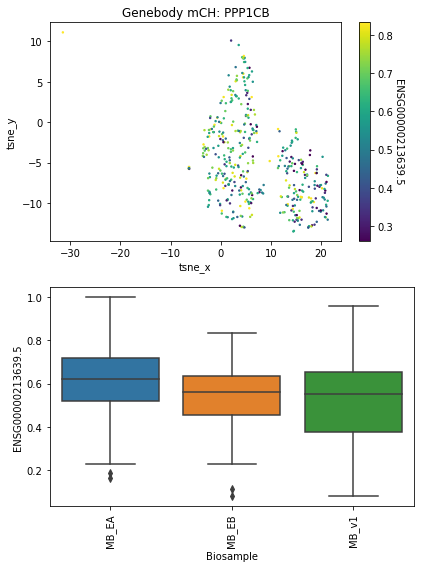

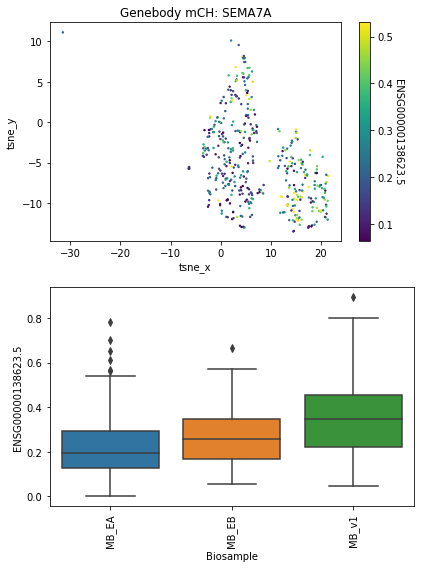

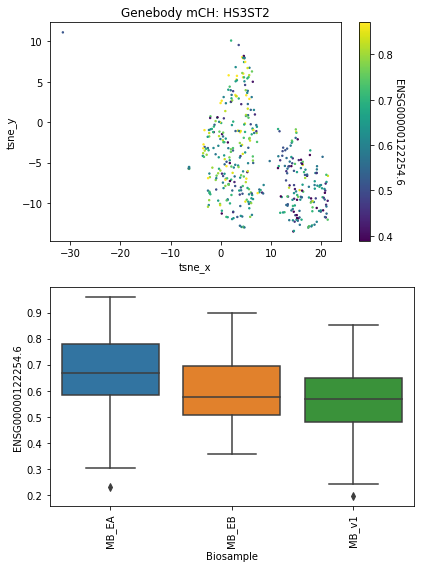

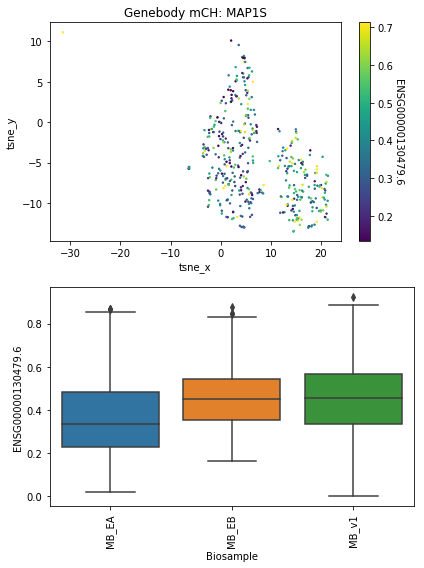

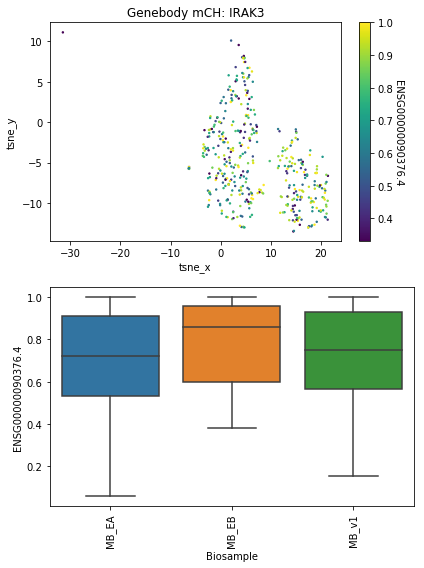

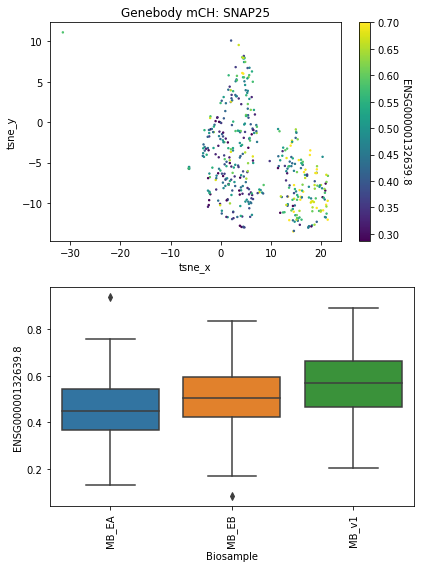

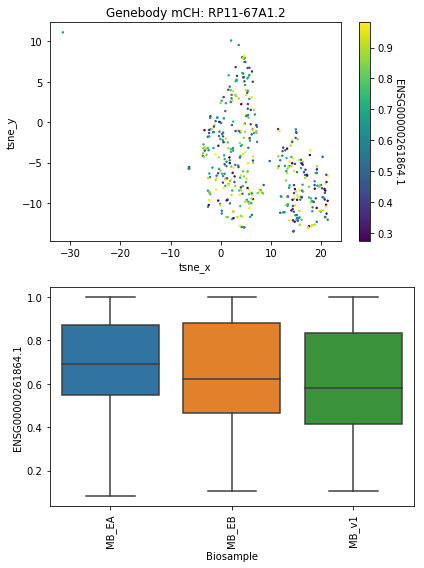

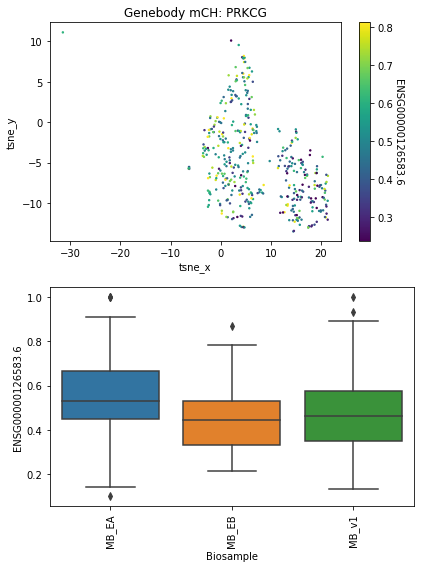

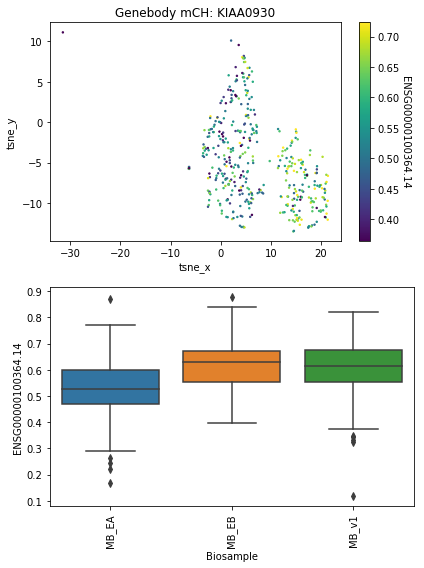

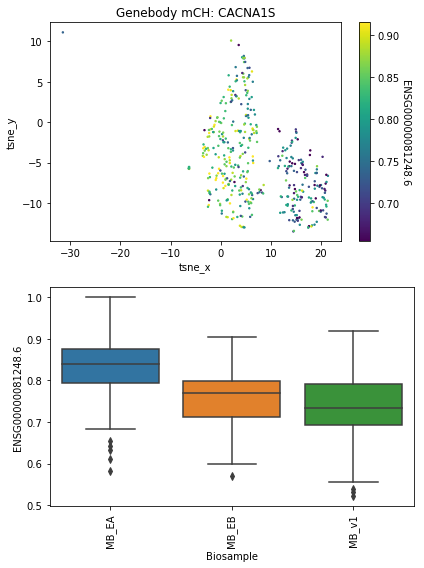

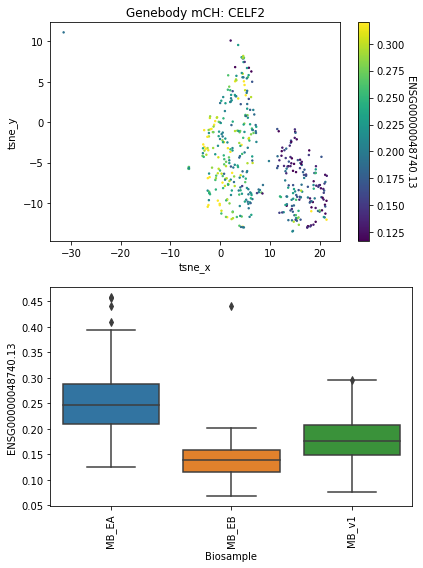

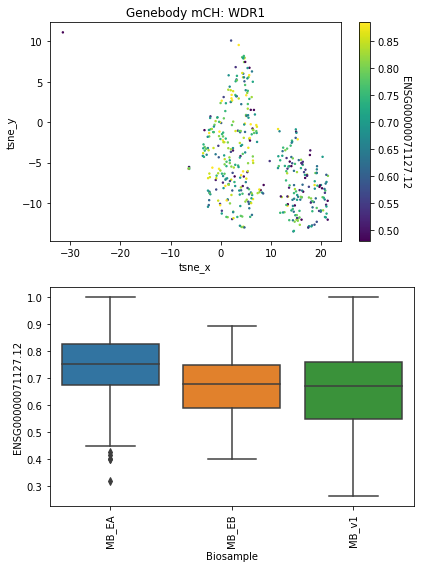

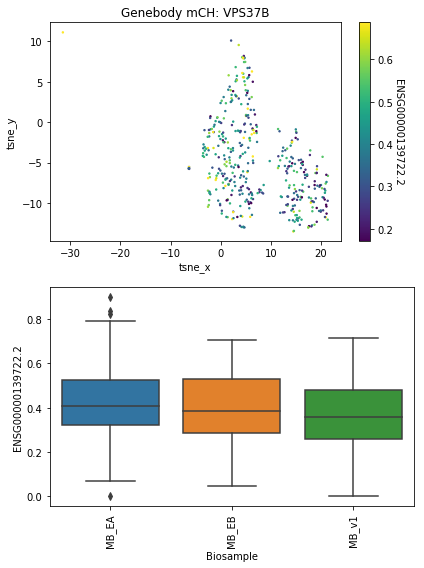

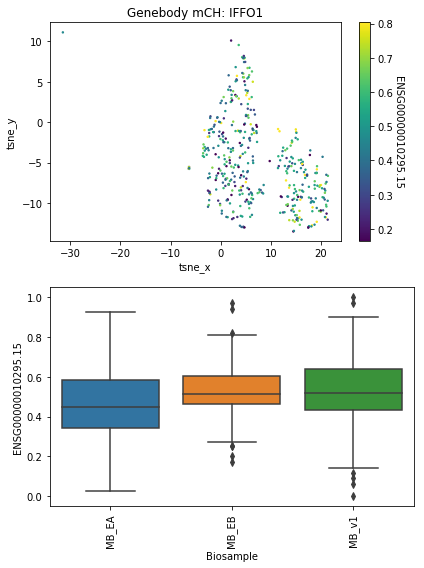

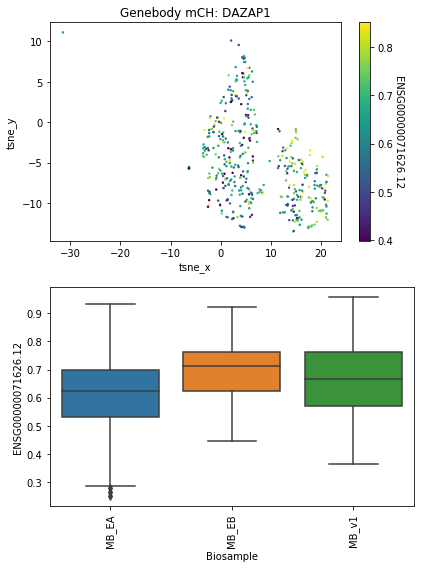

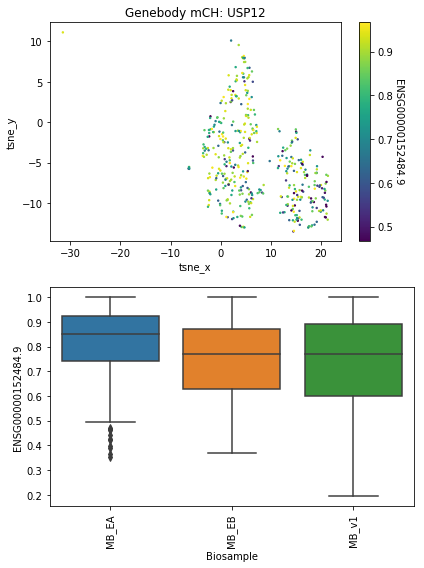

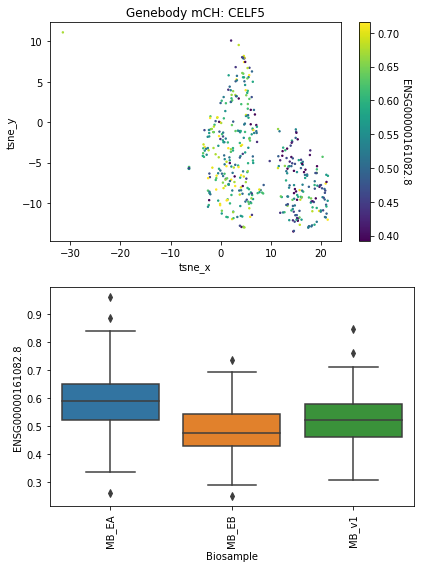

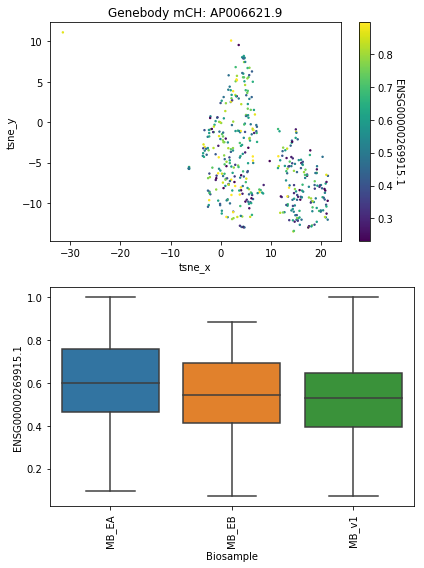

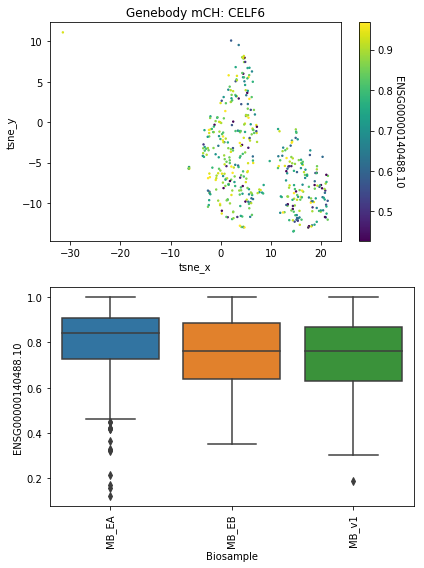

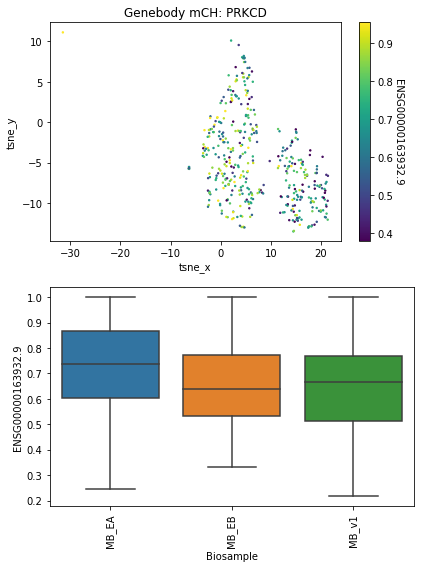

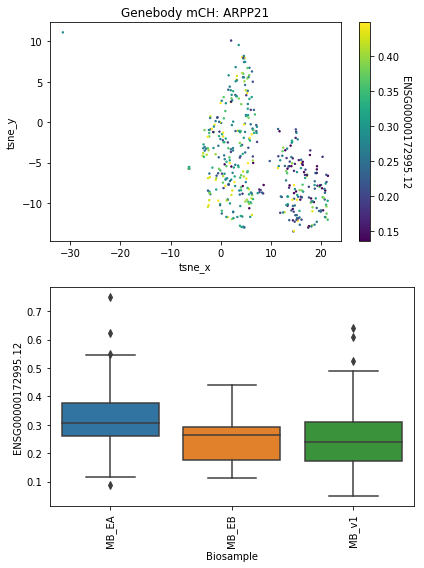

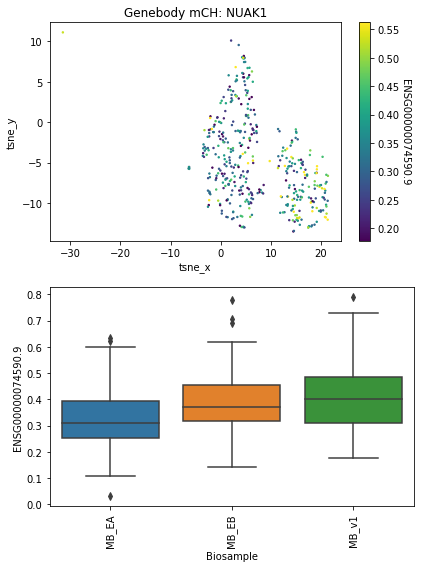

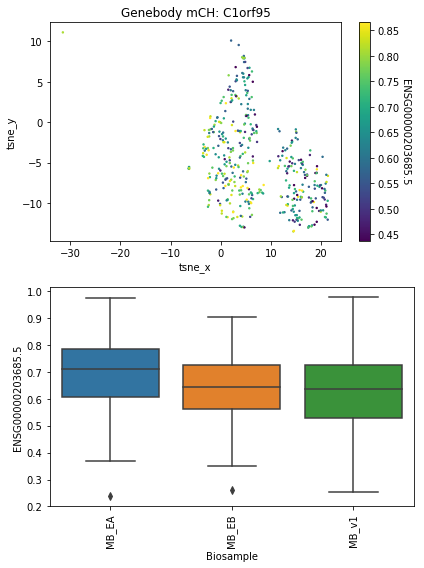

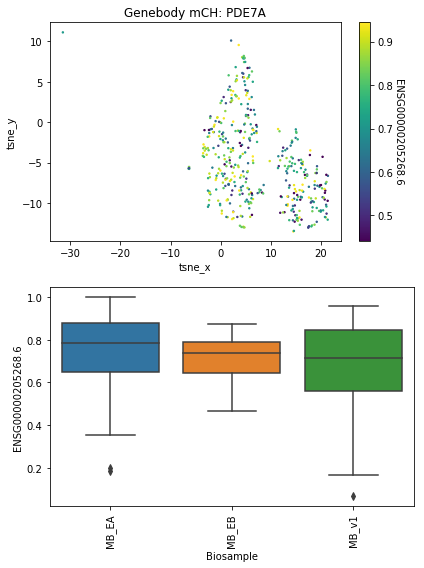

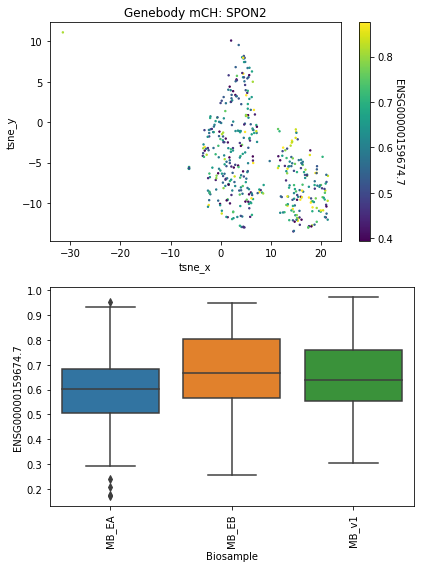

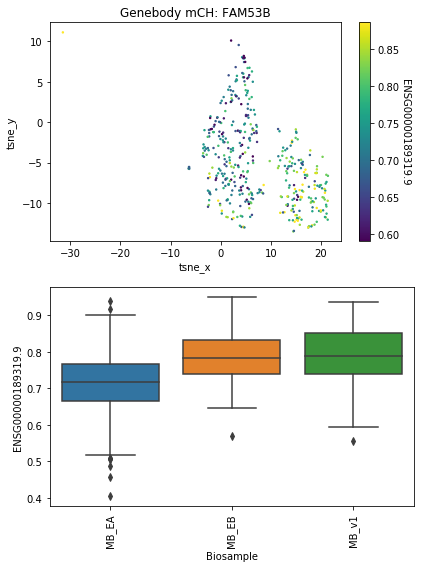

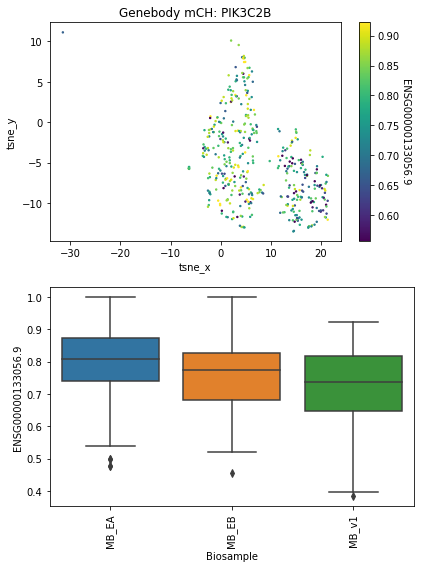

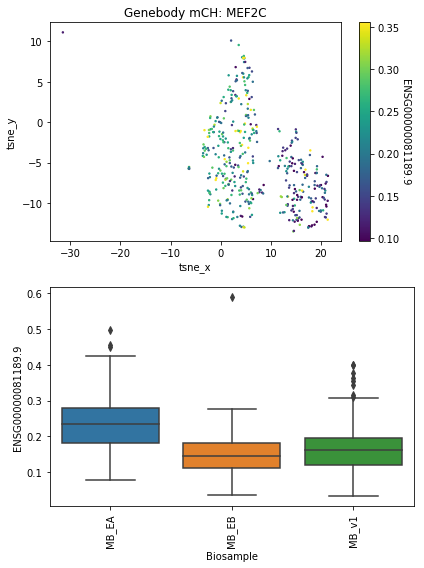

In [45]:
# tsne_box plot

for gene_id, gene_name in sr_top_genes_2.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [46]:
# overlapping genes (genes that seperates EA from two others)

sr_top_genes_both = sr_top_genes[sr_top_genes.index.intersection(sr_top_genes_2.index)]
sr_top_genes_both.to_frame()


geneName
geneID                     
ENSG00000048740.13    CELF2
ENSG00000081248.6   CACNA1S
ENSG00000081189.9     MEF2C
ENSG00000116852.10   KIF21B
ENSG00000189319.9    FAM53B

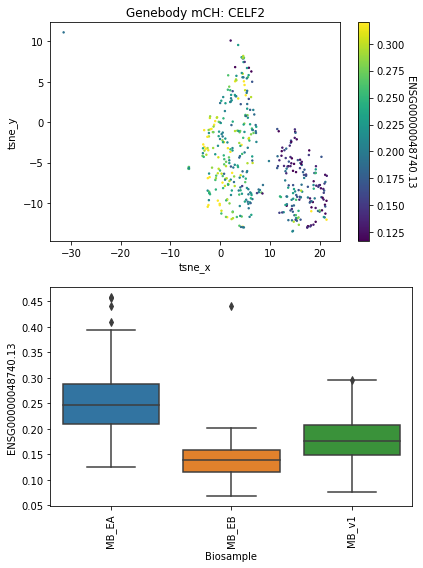

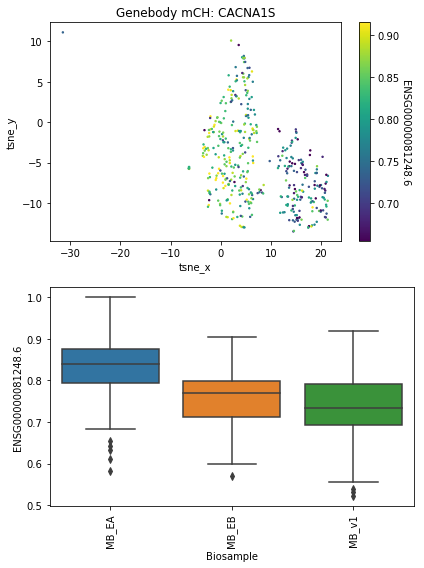

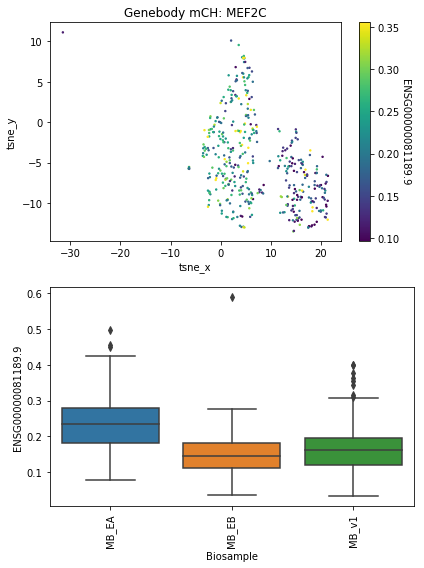

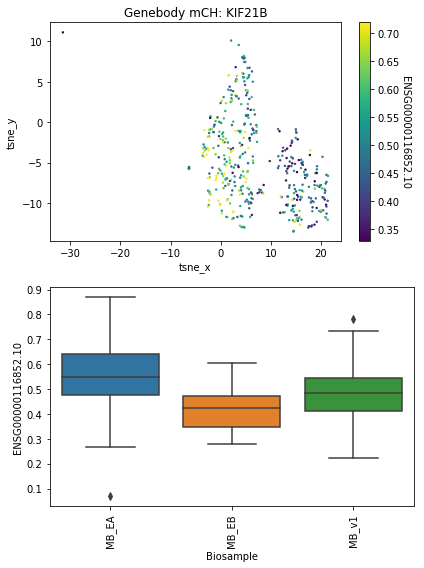

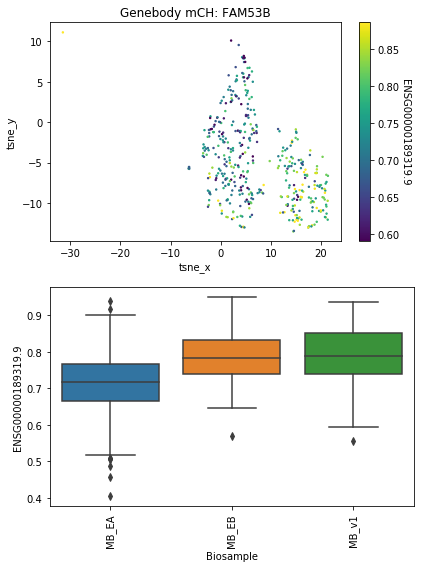

In [47]:
for gene_id, gene_name in sr_top_genes_both.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)